### ■ 유통 판매량 예측 및 재고 최적화
# 단계 2: 데이터 전처리와 모델링

<img src = "https://github.com/Jangrae/img/blob/master/store.png?raw=true" width=800, align="left"/>

# 수행 과제

다음과 같은 과정으로 프로젝트를 진행합니다.

#### 1. 환경 설정
- 이후 진행에 필요한 환경 설정을 수행합니다.

#### 2. 데이터 셋 구성하기 #1
- 44번 매장의 대표 상품(3, 7, 12) 데이터만을 대상으로 합니다.
- 상품별로 데이터셋을 구성해야 함수를 만들어 사용합니다.

#### 3. 1차 모델링
- Linear Regression 알고리즘을 사용해 모델링합니다.
- 모델의 검증 성능을 평가하고 기록합니다.

#### 4. 데이터 셋 구성하기 #2
- 모델의 성능을 높이기 위해 의미있는 변수를 추가합니다.
- 상품별로 데이터셋을 구성하는 함수를 만들어 사용합니다.

#### 5. 2차 모델링
- Linear Regression 알고리즘으로 다시 모델링합니다.
- 모델 성능을 높이기 위해 적절한 변수를 추가합니다.
- 데이터 셋에 변화를 주면서 변화되는 성능을 기록하고 비교합니다.

#### 6. 3차 모델링
- Random Forest, LightGBM 알고리즘으로 모델링하고 성능을 기록합니다.
- 하이퍼파라미터 튜닝은 하지 않습니다(모든 파라미터 기본값 사용).
- 우선 Linear Regression 모델보다 성능이 좋은지 비교하는 데 의미를 둡니다.

#### 7. 데이터 저장
- 이후 실습을 위해 최종 구성된 데이터프레임을 파일로 저장합니다.

# 1. 환경 설정

- 이후 진행에 필요한 환경 설정을 수행합니다.

## (1) 경로 설정

- 프로젝트 수행 환경에 맞게 파일 경로를 설정합니다.

### 1) 로컬 수행(Anaconda)
- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [8]:
# 기본 경로
path = ''

### 2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [10]:
# # 구글 드라이브 연결, 패스 지정
# import sys
# if 'google.colab' in sys.modules:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     path = '/content/drive/MyDrive/project/'

## (2) 라이브러리 불러오기

- 이후 사용할 라이브러리를 모두 불러옵니다.

In [12]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

- 시각화에 사용할 폰트 크기를 설정합니다.

In [14]:
# 시각화 폰트 사이즈 설정
plt.rc('font', size=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', linewidth=0.3)  # 축 테두리 굵기 설정

- 모델이 예측한 결과를 시각화할 때 다음 함수를 활용합니다.

In [16]:
# 함수 만들기
def plot_model_result(y_train, y_val, y_pred, title=None):
    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))
    y_pred = pd.Series(y_pred.reshape(-1,), index=y_val.index)

    # 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.plot(y_train, label='y_train', color='tab:blue', linewidth=0.8)
    plt.plot(y_val, label='y_val', color='tab:green', linewidth=0.8)
    plt.plot(y_pred, label='y_pred', color='tab:orange', linewidth=0.8)
    plt.title(f'{title}', size=15, pad=20)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(y_val, label = 'y_val', color='tab:green',  marker='o', markersize=2, linewidth=0.8)
    plt.plot(y_pred, label = 'y_pred', color='tab:orange',  marker='o', markersize=2, linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

## (3) 데이터 불러오기

- 이후 분석 대상이 되는 파일을 불러오고 기본 정보를 확인합니다.

### 1) 데이터 불러오기

- 분석 대상 데이터를 불러옵니다.
- 데이터프레임 이름은 다음과 같이 통일합니다.
    - sales: 판매 정보
    - orders: 고객 방문수
    - oil_price: 휘발유 가격
    - stores: 매장 정보
    - products: 상품 정보
- 날짜 데이터를 갖는 date 변수는 편의를 위해 datetime 형으로 변경합니다.

In [19]:
# 데이터 불러오기
sales = pd.read_csv(path + 'sales_train.csv')
orders = pd.read_csv(path + 'orders_train.csv')
oil_price = pd.read_csv(path + 'oil_price_train.csv')
stores = pd.read_csv(path + 'stores.csv')
products = pd.read_csv(path + 'products.csv')

In [20]:
# datetime 형으로 변환
sales['date'] = pd.to_datetime(sales['date'] )
oil_price['date'] = pd.to_datetime(oil_price['date'] )
orders['date'] = pd.to_datetime(orders['date'] )

### 2) 기본 정보 확인

- 각 데이터의 기본 정보를 확인합니다.

In [22]:
sales.describe() # 2014-01-02 00:00:00 ~ 2017-02-28 00:00:00

date       store_id            qty  \
count                         929880  929880.000000  929880.000000   
mean   2015-07-31 17:16:05.853659136      27.500000     657.044013   
min              2014-01-02 00:00:00       1.000000       0.000000   
25%              2014-10-15 18:00:00      14.000000      10.000000   
50%              2015-07-31 12:00:00      27.500000      89.000000   
75%              2016-05-15 06:00:00      41.000000     567.000000   
max              2017-02-28 00:00:00      54.000000  124717.000000   
std                              NaN      15.585793    1498.124239   

          product_id  
count  929880.000000  
mean       17.133333  
min         3.000000  
25%         8.000000  
50%        15.000000  
75%        27.000000  
max        38.000000  
std        10.340003

In [23]:
orders.describe() # 2014-01-02 00:00:00 ~ 2017-02-28 00:00:00

date      store_id         count
count                          57554  57554.000000  57554.000000
mean   2015-08-15 08:42:56.557667328     27.021458   1692.804723
min              2014-01-02 00:00:00      1.000000      5.000000
25%              2014-11-03 00:00:00     13.000000   1038.000000
50%              2015-08-25 00:00:00     27.000000   1390.000000
75%              2016-05-28 00:00:00     40.000000   2071.000000
max              2017-02-28 00:00:00     54.000000   8359.000000
std                              NaN     15.599275    970.948641

In [24]:
oil_price.describe() # 2014-01-02 00:00:00 ~ 2017-02-28 00:00:00

date   wti_price
count                            822  795.000000
mean   2015-08-01 13:45:06.569342976   61.279082
min              2014-01-02 00:00:00   26.190000
25%              2014-10-16 06:00:00   44.950000
50%              2015-08-01 12:00:00   50.720000
75%              2016-05-16 18:00:00   82.805000
max              2017-02-28 00:00:00  107.950000
std                              NaN   23.803058

In [25]:
stores.value_counts() # date 시계열 정보는 없음 대신 매장 정보를 알 수 있음
# target 매장 id: 44        도시:Saint Paul     주: Minnesota       store_ type:1  

store_id  city           state           store_type
1         Saint Paul     Minnesota       4             1
41        Richmond       Virginia        4             1
30        Raleigh        North Carolina  3             1
31        Indianapolis   Indiana         2             1
32        Raleigh        North Carolina  3             1
33        Bloomington    Indiana         3             1
34        Raleigh        North Carolina  2             1
35        Asheville      North Carolina  3             1
36        Wilmington     North Carolina  5             1
37        Atlanta        Georgia         4             1
38        Columbus       Ohio            4             1
39        Atlanta        Georgia         2             1
40        Richmond       Virginia        3             1
42        Atlanta        Georgia         4             1
2         Saint Paul     Minnesota       4             1
43        Albany         New York        5             1
44        Saint Paul     Minnesota  

In [26]:
products.value_counts() # 상품 정보 ,   
# product_id  product_code  subcategory      category         leadtime  price
# 3           DB001         Beverage         Drink            2         8
# 7           HC001         Cleaning         Household Goods  2         15
# 12          GA001         Milk             Food             2         6

product_id  product_code  subcategory      category         leadtime  price
3           DB001         Beverage         Drink            2         8        1
5           FB001         BAKERY           Food             2         6        1
7           HC001         Cleaning         Household Goods  2         15       1
8           FM001         Yogurt           Food             2         4        1
10          GE001         EGGS             Grocery          2         5        1
11          FF001         Frozen           Food             2         29       1
12          GA001         Milk             Food             2         6        1
15          HK002         Kitchen          Household Goods  2         41       1
16          HK001         Kitchen          Household Goods  2         23       1
20          HG001         Gardening Tools  Household Goods  2         50       1
24          GM001         Meats            Grocery          3         17       1
27          HH001         Home Ap

# 2. 데이터 셋 구성하기 #1

- 44번 매장의 데이터만을 대상으로 합니다.
- 대표 상품(3, 7, 12) 데이터만을 대상으로 합니다.

- 우선 다음과 같은 변수만을 갖는 기본 데이터 셋을 구성합니다.
    - date: 날짜
    - qty: 판매량
    - count: 고객 방문수
    - weekday: 요일(Monday ~ Sunday)
    - month: 월(1 ~ 12)
    - wti_price: 최근 14일 동안의 휘발유 가격 평균
    - target: 예측해야 하는 판매량
- 참고: 요일과 월은 다음 형태로 얻을 수 있습니다.

~~~
df['요일'] = df['날짜'].dt.day_name()
df['월'] = df['날짜'].dt.month
~~~

- 참고: 최근 14일 간의 가격 평균은 다음 형태로 얻을 수 있습니다.

~~~
df['가격'].rolling(14, min_periods=1).mean()
~~~
- target 즉, 예측해야 하는 판매량은 상품의 leadtime 이후의 판매량입니다.
- 예를 들어 5월 2일, 상품 leadtIme이 2이면 5월 4일 판매량이 예측해야 하는 판매량입니다.

## (1) 함수 만들기

- 매장번호, 상품번호를 매개변수로 받아 위 처리 결과를 반환하는 함수를 만듭니다.
    - 함수 이름: make_dataset
    - 입력: 매장번호(store_id), 상품번호(product_id)
- 사용예: data05 = make_dataset(44, 5)

In [29]:
# 함수 만들기
def make_dataset_prototype(store_id, product_id): 
    '''
    products , sales , orders 데이터셋에서 store_id에 해당하는 데이터들을 가져옴 
    col = [date	qty	 count	weekday	 month	wti_price	target]
    
    '''
    # 데이터 준비
    leadtime = products.loc[products['product_id']==product_id, 'leadtime'].values[0]
    temp1 = sales.loc[(sales['store_id']==store_id) & (sales['product_id']==product_id), ['date', 'qty']]
    temp2 = orders.loc[orders['store_id']==store_id, ['date', 'count']]
    temp3 = pd.merge(temp1, temp2, on='date', how='left')

    # 날짜 요소 추출
    temp3['weekday'] = temp3['date'].dt.day_name()
    temp3['month'] = temp3['date'].dt.month

    # Oil Price
    temp3 = pd.merge(temp3, oil_price, on='date', how='left')
    temp3['wti_price'] = temp3['wti_price'].rolling(14, min_periods=1).mean()# 지난 14일간 유가 평균 

    # Target 추가   = 2일 후 판매량을 예측 
    temp3['target'] = temp3['qty'].shift(-leadtime)

    # 결측치 처리
    temp3.interpolate(method='linear', inplace=True)
    temp3.bfill(inplace=True)

    # 결과 반환
    return temp3

## (2) 데이터 셋 구성

- 위 함수를 사용해 상품별로 데이터셋을 각각 구성합니다.
- 데이터프레임 이름은 data03, data07, data12로 합니다.

In [31]:
# 상품별 데이터 셋
data03 = make_dataset_prototype(44, 3)
data07 = make_dataset_prototype(44, 7)
data12 = make_dataset_prototype(44, 12)

In [32]:
# 확인
display(data03.head())
display(data07.head())
display(data12.head())

date      qty   count   weekday  month  wti_price   target
0 2014-01-02   9853.0  4422.0  Thursday      1  95.140000  15153.0
1 2014-01-03   8647.0  4167.0    Friday      1  94.400000  15606.0
2 2014-01-04  15153.0  5341.0  Saturday      1  94.400000   7900.0
3 2014-01-05  15606.0  5123.0    Sunday      1  94.400000   7188.0
4 2014-01-06   7900.0  3917.0    Monday      1  93.973333   8800.0

date     qty   count   weekday  month  wti_price  target
0 2014-01-02  3181.0  4422.0  Thursday      1  95.140000  4466.0
1 2014-01-03  3036.0  4167.0    Friday      1  94.400000  4582.0
2 2014-01-04  4466.0  5341.0  Saturday      1  94.400000  2536.0
3 2014-01-05  4582.0  5123.0    Sunday      1  94.400000  2473.0
4 2014-01-06  2536.0  3917.0    Monday      1  93.973333  3003.0

date      qty   count   weekday  month  wti_price   target
0 2014-01-02   9647.0  4422.0  Thursday      1  95.140000  14188.0
1 2014-01-03   8879.0  4167.0    Friday      1  94.400000  14490.0
2 2014-01-04  14188.0  5341.0  Saturday      1  94.400000   7614.0
3 2014-01-05  14490.0  5123.0    Sunday      1  94.400000   7124.0
4 2014-01-06   7614.0  3917.0    Monday      1  93.973333   8683.0

# 3. 1차 모델링: 기준 모델

- Linear Regression 알고리즘을 사용해 모델링한 후 성능을 검증합니다.
- 검증용 데이터는 학습용 데이터에서 최근 120일간의 데이터를 사용합니다.
- 모델링 과정에서 변수 이름은 x_train, x_val, y_train, y_val, y_pred을 사용합니다.

## (1) 함수 만들기

- 데이터를 받아 전처리 후 x_train, x_val, y_train, y_val를 반환하는 함수를 만듭니다.
    - 함수 이름: preproc
    - 입력: 데이터(data)
    - 처리: x와 y 분리, x 가변수화, 학습용/검증용 분리

- 사용예: x_train, x_val, y_train, y_val = preproc(data05)

In [35]:
# 함수 만들기
def preproc(data):
    # x, y 분리
    y= data['target']
    x= data.drop(columns= ['date','target'])
    # 가변수화 : 가변수화 할 컬럼 =  weekday , month 
    dummy_cols = ['weekday','month']
    months = [1,2,3,4,5,6,7,8,9,10,11,12]
    x['month'] = pd.Categorical(x['month'],categories= months)
    x = pd.get_dummies(data=x, columns = dummy_cols , drop_first=True)

    # 학습용, 검증용 분리
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=120, shuffle =False)

    # 결과 반환
    return x_train, x_val, y_train, y_val

## (2) 상품 3 모델링

- 모델 이름은 model03_lin로 합니다.

In [37]:
data03

date      qty   count   weekday  month  wti_price   target
0    2014-01-02   9853.0  4422.0  Thursday      1  95.140000  15153.0
1    2014-01-03   8647.0  4167.0    Friday      1  94.400000  15606.0
2    2014-01-04  15153.0  5341.0  Saturday      1  94.400000   7900.0
3    2014-01-05  15606.0  5123.0    Sunday      1  94.400000   7188.0
4    2014-01-06   7900.0  3917.0    Monday      1  93.973333   8800.0
...         ...      ...     ...       ...    ...        ...      ...
1143 2017-02-24  10208.0  4549.0    Friday      2  53.577778  10108.0
1144 2017-02-25  12361.0  4619.0  Saturday      2  53.577778  10006.0
1145 2017-02-26  10108.0  3877.0    Sunday      2  53.577778  14374.0
1146 2017-02-27  10006.0  3961.0    Monday      2  53.697778  14374.0
1147 2017-02-28  14374.0  4589.0   Tuesday      2  53.785556  14374.0

[1148 rows x 7 columns]

In [38]:
x_train, x_val, y_train, y_val = preproc(data03)



In [39]:
x_train

qty   count  wti_price  weekday_Monday  weekday_Saturday  \
0      9853.0  4422.0  95.140000           False             False   
1      8647.0  4167.0  94.400000           False             False   
2     15153.0  5341.0  94.400000           False              True   
3     15606.0  5123.0  94.400000           False             False   
4      7900.0  3917.0  93.973333            True             False   
...       ...     ...        ...             ...               ...   
1023   7053.0  3619.0  50.337000           False             False   
1024   8260.0  4039.0  50.198000           False             False   
1025   6668.0  3569.0  50.122000           False             False   
1026   9463.0  4178.0  49.959000           False             False   
1027  14177.0  4887.0  49.959000           False              True   

      weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
0              False              True            False              False   
1              False             False            False              False   
2              False             False            False              False   
3               True             False            False              False   
4              False             False            False              False   
...              ...               ...              ...                ...   
1023           False             False             True              False   
1024           False             False            False               True   
1025           False              True            False              False   
1026           False             False            False              False   
1027           False             False            False              False   

      month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
0       False    False    False    False    False    False    False    False   
1       False    False    False    False    False    False    False    False   
2       False    False    False    False    False    False    False    False   
3       False    False    False    False    False    False    False    False   
4       False    False    False    False    False    False    False    False   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1023    False    False    False    False    False    False    False    False   
1024    False    False    False    False    False    False    False    False   
1025    False    False    False    False    False    False    False    False   
1026    False    False    False    False    False    False    False    False   
1027    False    False    False    False    False    False    False    False   

      month_10  month_11  month_12  
0        False     False     False  
1        False     False     False  
2        False     False     False  
3        False     False     False  
4        False     False     False  
...        ...       ...       ...  
1023      True     False     False  
1024      True     False     False  
1025      True     False     False  
1026      True     False     False  
1027      True     False     False  

[1028 rows x 20 columns]

In [40]:
y_train

0       15153.0
1       15606.0
2        7900.0
3        7188.0
4        8800.0
         ...   
1023     6668.0
1024     9463.0
1025    14177.0
1026    15245.0
1027     7868.0
Name: target, Length: 1028, dtype: float64

## (3) 상품 7 모델링

- 모델 이름은 model07_lin로 합니다.

In [42]:
x_train, x_val, y_train, y_val = preproc(data07)

## (4) 상품 12 모델링

- 모델 이름은 model12_lin로 합니다.

In [44]:
x_train, x_val, y_train, y_val = preproc(data12)

# 4. 데이터 셋 구성하기 #2

- 모델의 성능을 높이기 위해 의미있는 변수를 추가합니다.
- 예를 들면 다음과 같은 변수들을 갖는 데이터 셋을 구성할 수 있습니다.
    - date: 날짜
    - qty: 판매량
    - count: 고객 방문수
    - weekday: 요일
    - month: 월
    - wti_price: 유가
    - category_qty: 동일 카테고리 판매량 합계
    - city_custcount: 동일 지역 방문객 수
    - qty_lag_1: 1일 전 판매량
    - qty_lag_7_mean: 최근 7일간 판매량 평균
    - 기타 등등...
    - target: 예측해야 하는 판매량

## (1) 함수 다시 만들기

- 적절한 변수를 추가하도록 위 make_dataset 함수를 수정합니다.    - 함수 이름: make_dataset    - 입력: 매장번호(store_id), 상품번호(product_id)

### (추가) 미국 국체 금리 정보 가져오기

In [48]:
!pip install yfinance

In [49]:
import yfinance as yf
# 미국 10년 국채 금리 데이터를 가져오는 예시 (US10Y)
finance = yf.download('^TNX', start='2014-01-01', end='2017-02-28')  # 미국 10년 국채 금리

finance = finance.reset_index()
# 미국 10년 국채 금리는 시장에서 중요한 경제적 신뢰도를 반영합니다. 
# 높은 금리는 일반적으로 경제 성장과 인플레이션 우려와 관련이 있고,  >> 높으면  경제성장
# 낮은 금리는 경기 침체나 경제 불확실성과 관련이 있습니다           >> 낮으면 경제 침체
# 이중에서 당일 종가 데이터만 가져오기에 Close 만 가져오자  (Adj Close 수정된 종가는 Close와 같음 )
# # 'Date' 컬럼에서 날짜만 추출하여 '년-월-일' 형식으로 변경
finance['Date'] = pd.to_datetime(finance['Date']).dt.strftime('%Y-%m-%d')

# # 'Close'와 'Date' 컬럼만 선택
bond_data = finance[['Date', 'Close']]
# ticket, price 인덱스 제거 
bond_data = bond_data.reset_index()

# 날짜를 인덱스로 설정하고 날짜 범위에 맞는 모든 날짜 생성
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
date_range = pd.date_range(start='2014-01-02', end='2017-02-28')

# 모든 날짜에 대해 종가를 채우기 전에, 데이터를 날짜별로 정렬
data_sorted = bond_data.set_index('Date').reindex(date_range)

# 전날 종가로 결측치를 채움
data_sorted['Close'] = data_sorted['Close'].fillna(method='ffill')

# 인덱스를 컬럼으로 다시 리셋
data_final = data_sorted.reset_index()
# 불필요한 컬럼 제거: 'Price', 'level_0', 'index', 'Ticker' 등을 제거
data_final_cleaned = data_final.drop(columns=['index'])

# 컬럼명 변경
data_final_cleaned.rename(columns={'level_0': 'date'}, inplace=True)
data_final_cleaned.columns = ['date', 'FOMC']
# 결과 확인
interest_rate = data_final_cleaned.copy()
interest_rate

[*********************100%***********************]  1 of 1 completed


date   FOMC
0    2014-01-02  2.985
1    2014-01-03  2.995
2    2014-01-04  2.995
3    2014-01-05  2.995
4    2014-01-06  2.961
...         ...    ...
1149 2017-02-24  2.317
1150 2017-02-25  2.317
1151 2017-02-26  2.317
1152 2017-02-27  2.369
1153 2017-02-28  2.369

[1154 rows x 2 columns]

In [50]:
# # 함수 만들기(수정 필요)(양정우 버전)
# def make_dataset(store_id, product_id):
#     # 데이터 준비
#     leadtime = products.loc[products['product_id']==product_id, 'leadtime'].values[0]
#     temp1 = sales.loc[(sales['store_id']==store_id) & (sales['product_id']==product_id), ['date', 'qty']]
#     temp2 = orders.loc[orders['store_id']==store_id, ['date', 'count']]
#     temp3 = pd.merge(temp1, temp2, on='date', how='left')
    
#     # 날짜 요소 추출
#     temp3['weekday'] = temp3['date'].dt.day_name()
#     temp3['month'] = temp3['date'].dt.month
    
#     # Oil Price
#     temp3 = pd.merge(temp3, oil_price, on='date', how='left')
#     temp3['wti_price'] = temp3['wti_price'].rolling(14, min_periods=1).mean()

#     #category_qty: 동일 카테고리 판매량 합계
#     category_name =  products.loc[products['product_id'] ==product_id]['category'].values[0]
#     category_chain = products.loc[products['category']==category_name]['product_id'].values
#     related_sales = sales.loc[(sales['store_id'] == store_id) & (sales['product_id'].isin(category_chain))]
#     related_sales = related_sales.groupby('date')['qty'].sum().reset_index()
#     related_sales = related_sales.rename(columns={'qty':'category_qty'})
#     temp3 = pd.merge(temp3,related_sales,on='date',how='left')  

#     #city_custcount: 동일 지역 방문객 수  stores에  store_id ,  city ,state가 있음, orders에 store_id 와 count 가 있음                            
#     #city = Saint Paul 밖에 없음  [city를 기준]
#     city_name = stores.loc[stores['store_id']==store_id]['city'].values[0]
#     city_chain = stores.loc[stores['city']==city_name]['store_id'].values
#     related_count = orders.loc[(orders['store_id'].isin(city_chain))]
#     related_count = related_count.groupby('date')['count'].sum().reset_index()
#     related_count = related_count.rename(columns={'count':'city_custcount'})
#     temp3 = pd.merge(temp3,related_count,on='date',how='left')

#     #qty_lag_1: 1일 전 판매량    sales 안에 qty 열 
#     temp3['qty_lag_1'] = temp3['qty'].shift(1)
    
#     #qty_lag_2: 2일 전 판매량    sales 안에 qty 열 
#     temp3['qty_lag_2'] = temp3['qty'].shift(2)
    
#     #qty_lag_5: 5일 전 판매량    sales 안에 qty 열 
#     temp3['qty_lag_5'] = temp3['qty'].shift(5)
    
#     #qty_lag_7: 7일 전 판매량    sales 안에 qty 열 
#     temp3['qty_lag_7'] = temp3['qty'].shift(7)
    
#     #qty_lag_7_mean: 최근 7일간 판매량 평균
#     temp3['qty_lag_7_mean'] = temp3['qty'].rolling(7, min_periods=1).mean()

#     #qty_lag_14_mean: 최근 14일간 판매량 평균
#     temp3['qty_lag_14_mean'] = temp3['qty'].rolling(14, min_periods=1).mean()
    
#     # (추가) 특정요일 추가  >> 토, 일에 높은 판매량이 예상되므로 2일전  목,금 인지 여부를 넣으면 잘 파악할거같음 
#     temp3['predict_peek'] = temp3['weekday'].isin(['Thursday', 'Friday'])
#     # (추가) 미국 당일 금리를 추가 
#     temp3 = pd.merge(temp3, interest_rate, on='date', how='left')
#     # Target 추가
#     temp3['target'] = temp3['qty'].shift(-leadtime)

    
#     # 결측치 처리
#     temp3.interpolate(method='linear', inplace=True)
#     temp3.fillna(method='bfill', inplace=True)

#     # 결과 반환
#     return temp3

In [51]:
# 함수 만들기(수정 필요) (김명제님 )
def make_dataset(store_id, product_id):
    # 데이터 준비
    leadtime = products.loc[products['product_id']==product_id, 'leadtime'].values[0]
    temp1 = sales.loc[(sales['store_id']==store_id) & (sales['product_id']==product_id), ['date', 'qty']]
    temp2 = orders.loc[orders['store_id']==store_id, ['date', 'count']]
    temp3 = pd.merge(temp1, temp2, on='date', how='left')
 
    # 날짜 요소 추출
    temp3['weekday'] = temp3['date'].dt.day_name()
    temp3['month'] = temp3['date'].dt.month
 
    # Oil Price
    temp3 = pd.merge(temp3, oil_price, on='date', how='left')
    temp3['wti_price'] = temp3['wti_price'].rolling(14, min_periods=1).mean()
 
    # 추가(날짜)
    temp3['day'] = temp3['date'].dt.day
    temp3['is_weekend'] = temp3['weekday'].isin(['Saturday', 'Sunday']).astype(int)
    temp3['quarter'] = temp3['date'].dt.quarter
    temp3['is_quarter_start'] = temp3['date'].dt.is_quarter_start.astype(int)
    temp3['is_quarter_end'] = temp3['date'].dt.is_quarter_end.astype(int)
    temp3['week'] = temp3['date'].dt.isocalendar().week
    temp3['is_month_start'] = temp3['date'].dt.is_month_start.astype(int)
    temp3['is_month_end'] = temp3['date'].dt.is_month_end.astype(int)
    temp3['is_year_start'] = temp3['date'].dt.is_year_start.astype(int)
    temp3['is_year_end'] = temp3['date'].dt.is_year_end.astype(int)
 
    # 추가(qty lag)
    temp3['qty_lag_1'] = temp3['qty'].shift(1)
    temp3['qty_lag_2'] = temp3['qty'].shift(2)
    temp3['qty_lag_3'] = temp3['qty'].shift(3)
    temp3['qty_lag_4'] = temp3['qty'].shift(4)
    temp3['qty_lag_5'] = temp3['qty'].shift(5)
    temp3['qty_lag_6'] = temp3['qty'].shift(6)
    temp3['qty_lag_7'] = temp3['qty'].shift(7)
    temp3['qty_lag_14'] = temp3['qty'].shift(14)
 
    # 추가(방문수)
    temp3['count_mean3'] = temp3['count'].rolling(window=3, min_periods=1).mean()
    temp3['count_mean7'] = temp3['count'].rolling(window=7, min_periods=1).mean()
    temp3['count_mean14'] = temp3['count'].rolling(window=14, min_periods=1).mean()
    temp3['qty_per_customer'] = temp3['qty'] / temp3['count']
    temp3['count_std7'] = temp3['count'].rolling(window=7, min_periods=1).std()
 
    # 판매량
    temp3['qty_max7'] = temp3['qty'].rolling(window=7, min_periods=1).max()
    temp3['qty_min7'] = temp3['qty'].rolling(window=7, min_periods=1).min()
    temp3['qty_mean7'] = temp3['qty'].rolling(window=7, min_periods=1).mean()
    # 카테고리
    category = products.loc[products['product_id']==product_id, 'category'].values[0]
    category_products = products.loc[products['category']==category, 'product_id'].values
    category_sales = sales.loc[(sales['store_id']==store_id) &
                             (sales['product_id'].isin(category_products)),
                             ['date', 'qty']].groupby('date')['qty'].sum().reset_index()
    category_sales.columns = ['date', 'qty_category']
    temp3 = pd.merge(temp3, category_sales, on='date', how='left')
    temp3['category_mean7'] = temp3['qty_category'].rolling(window=7, min_periods=1).mean()
    temp3['category_min7'] = temp3['qty_category'].rolling(window=7, min_periods=1).min()

    # 주간 누적 판매량 (추가)
    temp3['weekly_qty_sum'] = temp3['qty'].rolling(7, min_periods=1).sum()
    # 도시
    city = stores.loc[stores['store_id']==store_id, 'city'].values[0]
    city_stores = stores.loc[stores['city']==city, 'store_id'].values
    city_customers = orders.loc[orders['store_id'].isin(city_stores),
                              ['date', 'count']].groupby('date')['count'].sum().reset_index()
    temp3 = pd.merge(temp3, city_customers, on='date', how='left', suffixes=('', '_city'))
    temp3['city_count_ma7'] = temp3['count_city'].rolling(window=7, min_periods=1).mean()
    temp3['city_count_std7'] = temp3['count_city'].rolling(window=7, min_periods=1).std()


    # (추가) 미국 당일 금리를 추가 
    temp3 = pd.merge(temp3, interest_rate, on='date', how='left') 
    # (추가) (요일별 평균)
    temp3['weekday_avg_qty'] = temp3.groupby('weekday')['qty'].transform('mean')
    #(추가) 월초 , 월밀 = 월급날 > 소비증가 > 매출증가 
    temp3['is_first_week'] = (temp3['date'].dt.day <= 7).astype(int)
    temp3['is_last_week'] = (temp3['date'].dt.day >= 25).astype(int)

    
    # Target 추가
    temp3['target'] = temp3['qty'].shift(-leadtime)
 
    # 결측치 처리
    temp3.interpolate(method='linear', inplace=True)
    temp3.fillna(method='bfill', inplace=True)
 
    # 결과 반환
    return temp3

## (2) 데이터 셋 구성

- 상품별 데이터 셋을 다시 구성합니다.
- 데이터프레임 이름은 data03, data07, data12로 합니다.

In [53]:
data03 = make_dataset(44,3)
data07 = make_dataset(44,7)
data12 = make_dataset(44,12)

In [54]:
data03

date      qty   count   weekday  month  wti_price  day  is_weekend  \
0    2014-01-02   9853.0  4422.0  Thursday      1  95.140000    2           0   
1    2014-01-03   8647.0  4167.0    Friday      1  94.400000    3           0   
2    2014-01-04  15153.0  5341.0  Saturday      1  94.400000    4           1   
3    2014-01-05  15606.0  5123.0    Sunday      1  94.400000    5           1   
4    2014-01-06   7900.0  3917.0    Monday      1  93.973333    6           0   
...         ...      ...     ...       ...    ...        ...  ...         ...   
1143 2017-02-24  10208.0  4549.0    Friday      2  53.577778   24           0   
1144 2017-02-25  12361.0  4619.0  Saturday      2  53.577778   25           1   
1145 2017-02-26  10108.0  3877.0    Sunday      2  53.577778   26           1   
1146 2017-02-27  10006.0  3961.0    Monday      2  53.697778   27           0   
1147 2017-02-28  14374.0  4589.0   Tuesday      2  53.785556   28           0   

      quarter  is_quarter_start  ...  category_min7  weekly_qty_sum  \
0           1                 0  ...        10142.0          9853.0   
1           1                 0  ...         8980.0         18500.0   
2           1                 0  ...         8980.0         33653.0   
3           1                 0  ...         8980.0         49259.0   
4           1                 0  ...         8083.0         57159.0   
...       ...               ...  ...            ...             ...   
1143        1                 0  ...         6143.0         67617.0   
1144        1                 0  ...         6143.0         63647.0   
1145        1                 0  ...         6143.0         61732.0   
1146        1                 0  ...         7415.0         65734.0   
1147        1                 0  ...         8118.0         72931.0   

      count_city  city_count_ma7  city_count_std7   FOMC  weekday_avg_qty  \
0        45969.0    45969.000000      2533.563597  2.985      6315.245399   
1        42386.0    44177.500000      2533.563597  2.995      7675.257669   
2        52293.0    46882.666667      5016.298669  2.995     11864.363636   
3        49199.0    47461.750000      4256.389501  2.995     12851.171779   
4        39105.0    45790.400000      5249.256404  2.961      7802.484848   
...          ...             ...              ...    ...              ...   
1143     43170.0    41286.571429      4518.085098  2.317      7675.257669   
1144     46801.0    40719.571429      3180.713749  2.317     11864.363636   
1145     38062.0    40437.142857      3335.235795  2.317     12851.171779   
1146     38858.0    40542.571429      3260.611438  2.369      7802.484848   
1147     45626.0    41581.571429      3588.869314  2.369      7070.333333   

      is_first_week  is_last_week   target  
0                 1             0  15153.0  
1                 1             0  15606.0  
2                 1             0   7900.0  
3                 1             0   7188.0  
4                 1             0   8800.0  
...             ...           ...      ...  
1143              0             0  10108.0  
1144              0             1  10006.0  
1145              0             1  14374.0  
1146              0             1  14374.0  
1147              0             1  14374.0  

[1148 rows x 44 columns]

# 5. 2차 모델링: 모델 성능 변화 확인

- Linear Regression 알고리즘으로 다시 모델링합니다.
- 적절한 변수를 추가하도록 위 make_dataset 함수를 반복해 수정합니다.
- 반복하는 과정에서 변화되는 성능을 기록하고 비교합니다.

## (1) 상품 3 모델링

- 모델 이름은 model03_lin로 합니다.

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
from sklearn.linear_model import LinearRegression

x_train, x_val, y_train, y_val = preproc(data03)
x_train = x_train.astype(float)
x_val = x_val.astype(float)

In [59]:
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

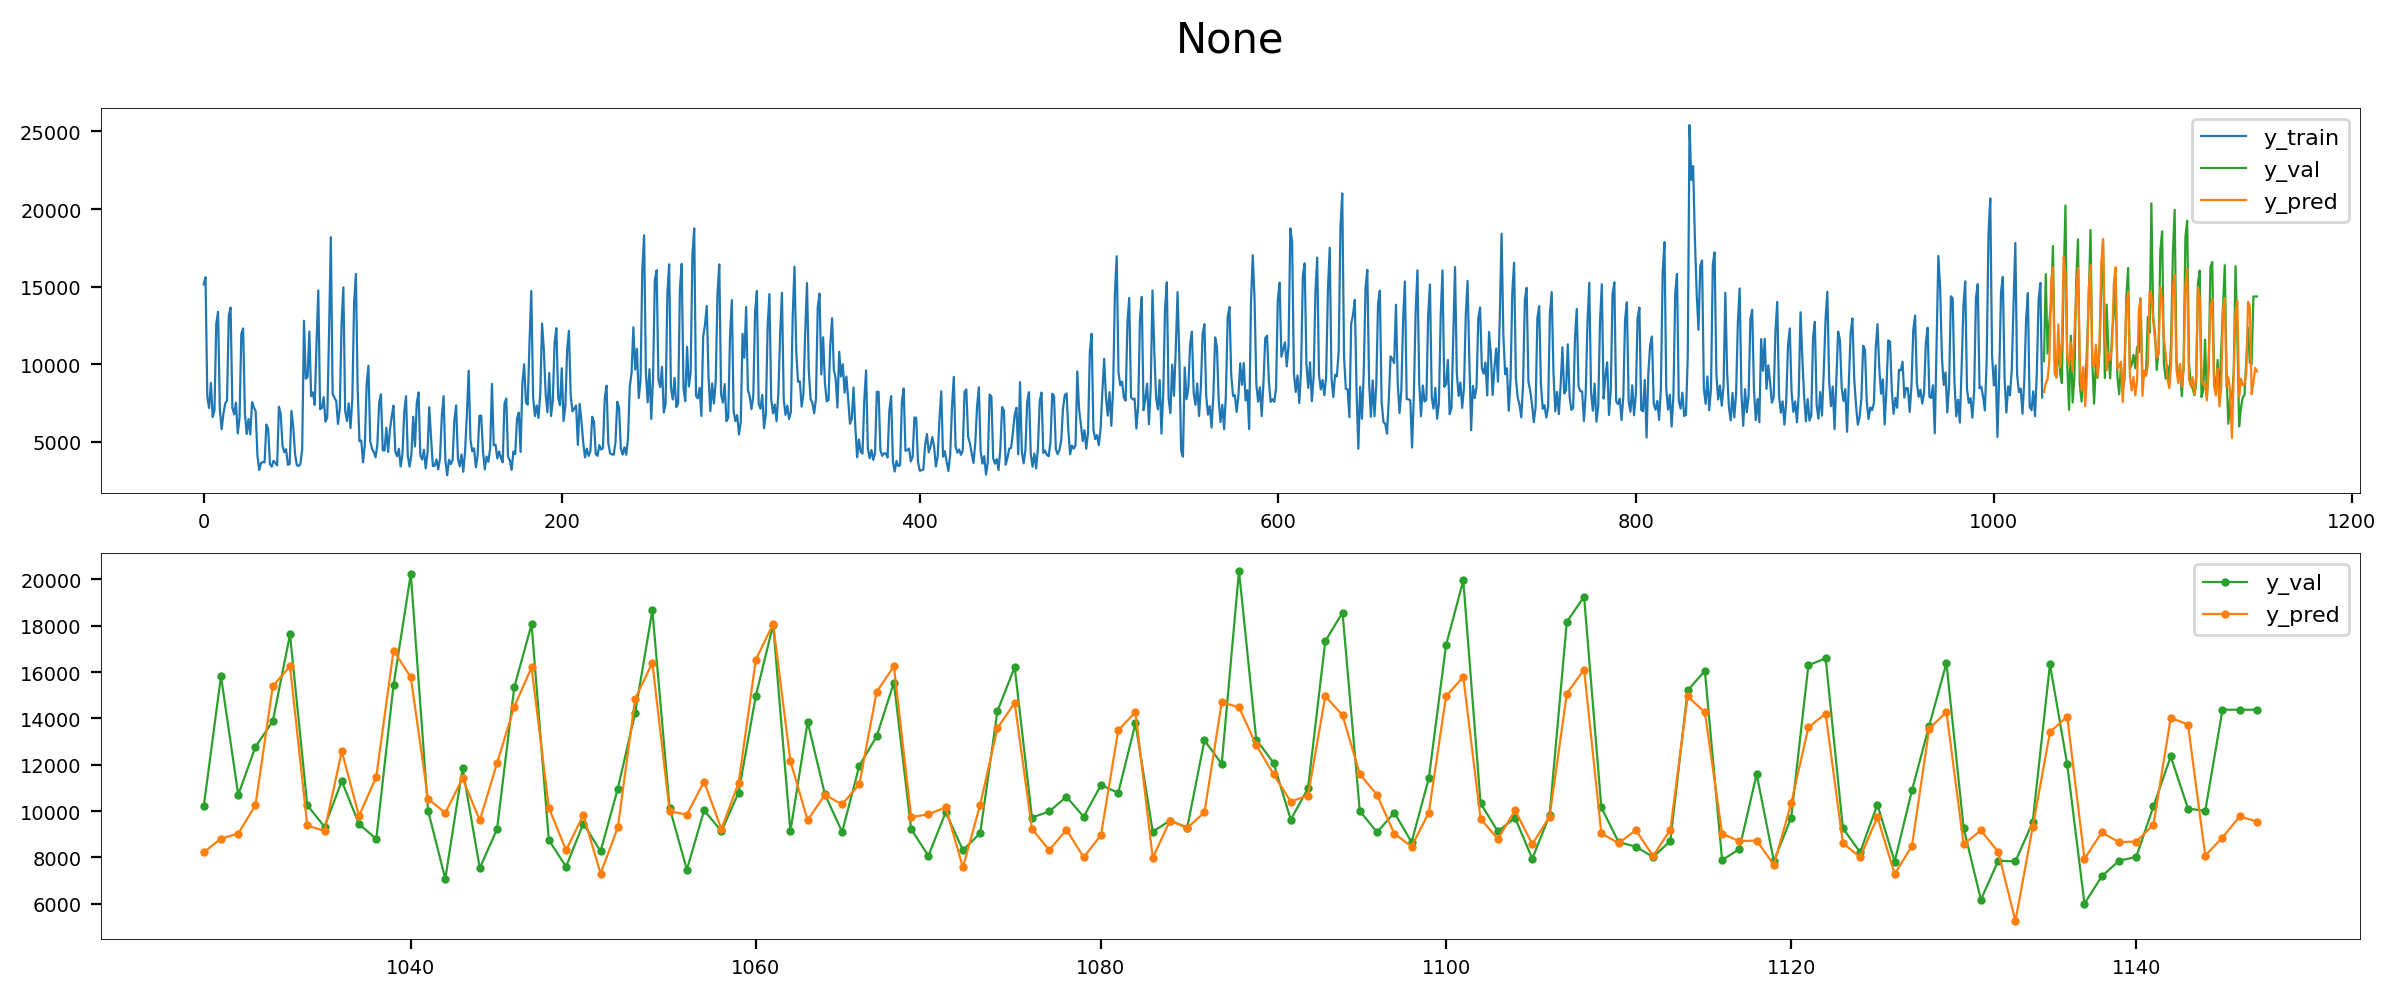

0.6428398039285756
RMSE: 2059.380826441333
MAE: 1542.6152695335445
MAPE: 13.24%
R2-Score: 0.6428398039285756


In [60]:
# Linear 선형회귀 모델은 모든 데이터 형식이 float으로 통일해야 합니다 > 가변수화 한 데이터의 타입 변경
model03_lin = LinearRegression()
model03_lin.fit(x_train,y_train)

y_pred = model03_lin.predict(x_val)
plot_model_result(y_train,y_val,y_pred)
print(model03_lin.score(x_val,y_val))

print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))

## (2) 상품 7 모델링

- 모델 이름은 model07_lin로 합니다.

In [62]:
x_train, x_val, y_train, y_val = preproc(data07)
x_train = x_train.astype(float)
x_val = x_val.astype(float)

In [63]:
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

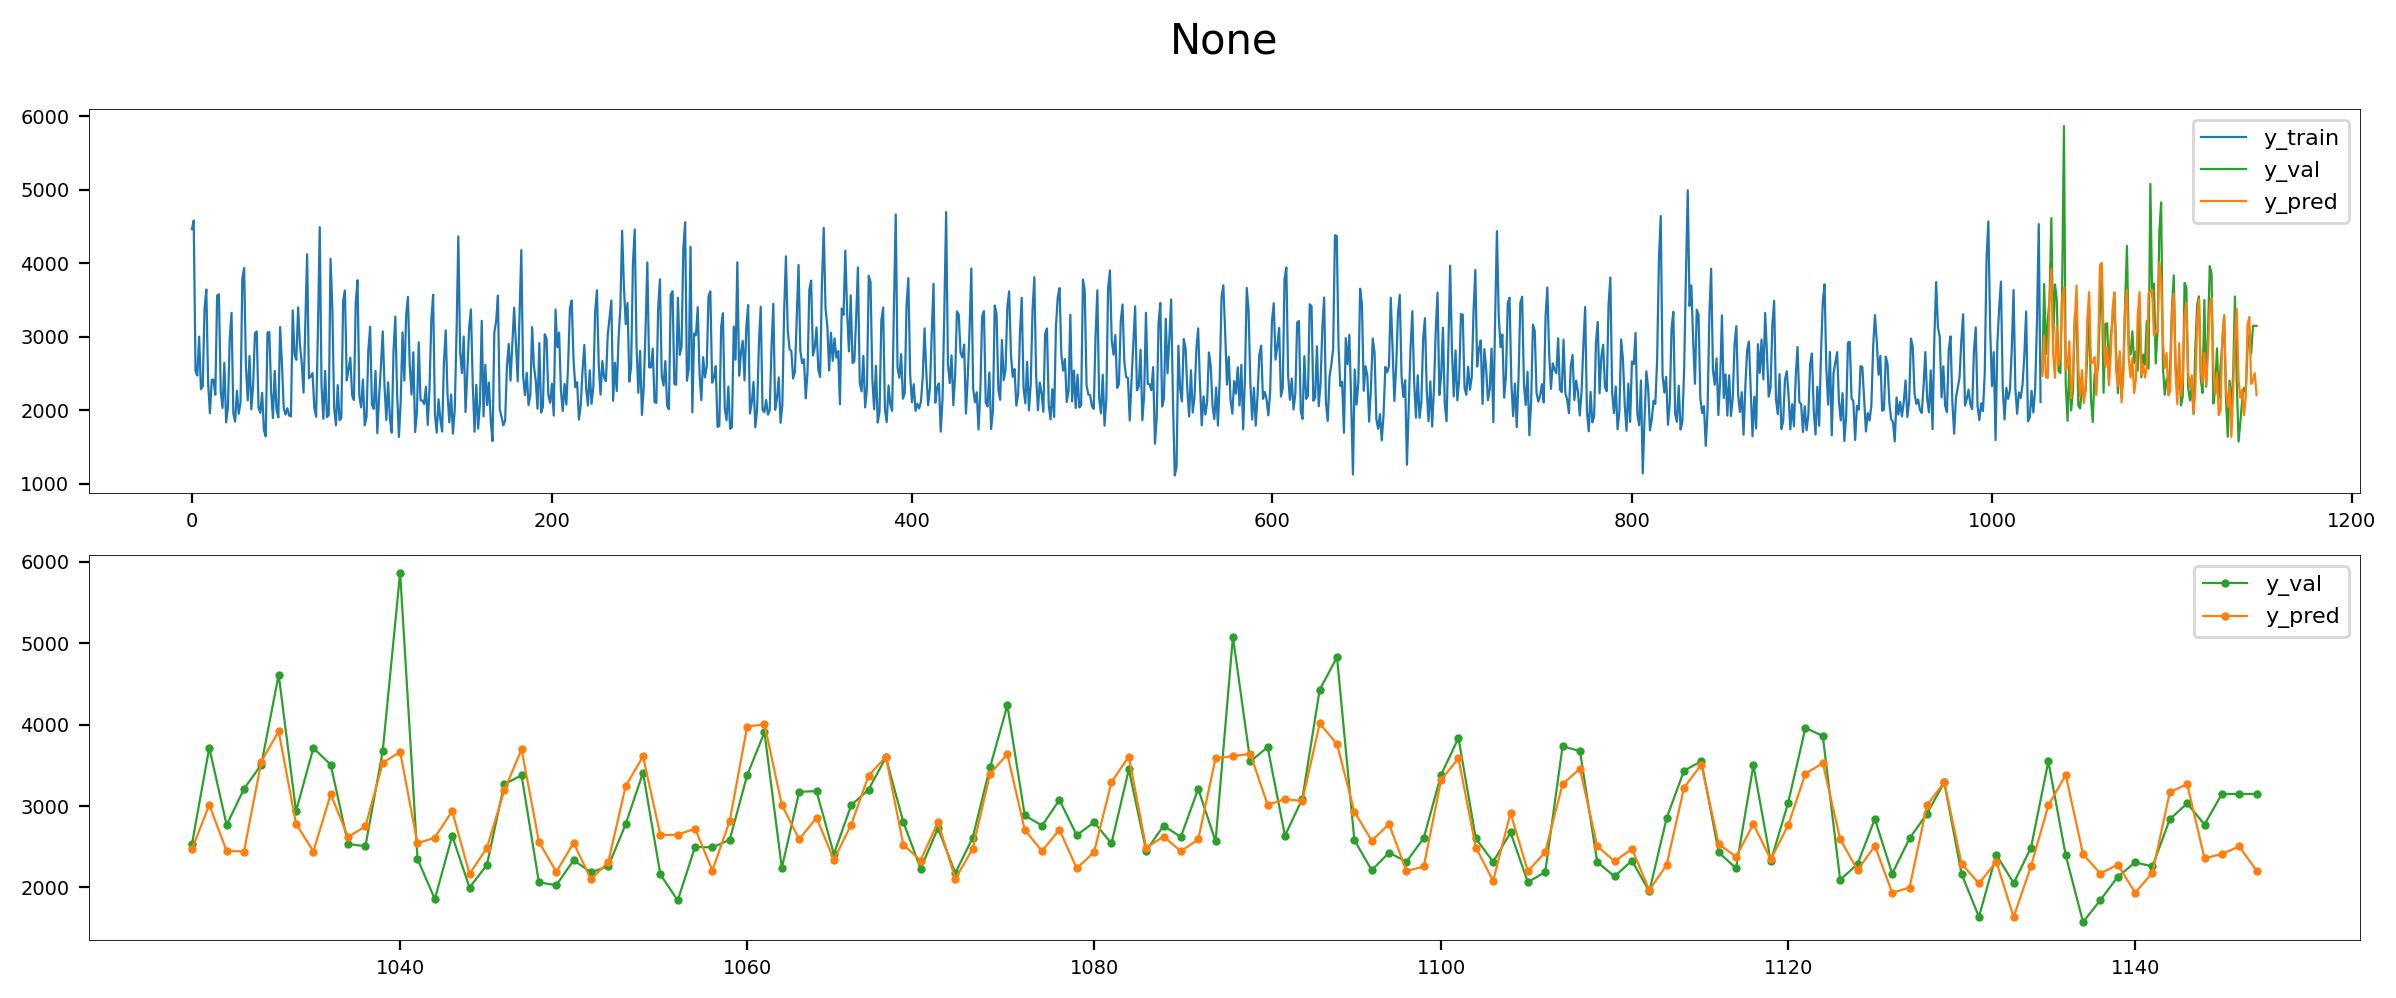

0.560810394289725
RMSE: 482.56215544995047
MAE: 354.10583705929196
MAPE: 12.40%
R2-Score: 0.560810394289725


In [64]:
model07_lin = LinearRegression()
model07_lin.fit(x_train,y_train)
y_pred = model07_lin.predict(x_val)

# 평가
plot_model_result(y_train,y_val,y_pred)
print(model07_lin.score(x_val,y_val))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))

## (3) 상품 12 모델링

- 모델 이름은 model12_lin로 합니다.

In [66]:
x_train, x_val, y_train, y_val = preproc(data12)
x_train = x_train.astype(float)
x_val = x_val.astype(float)

In [67]:
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

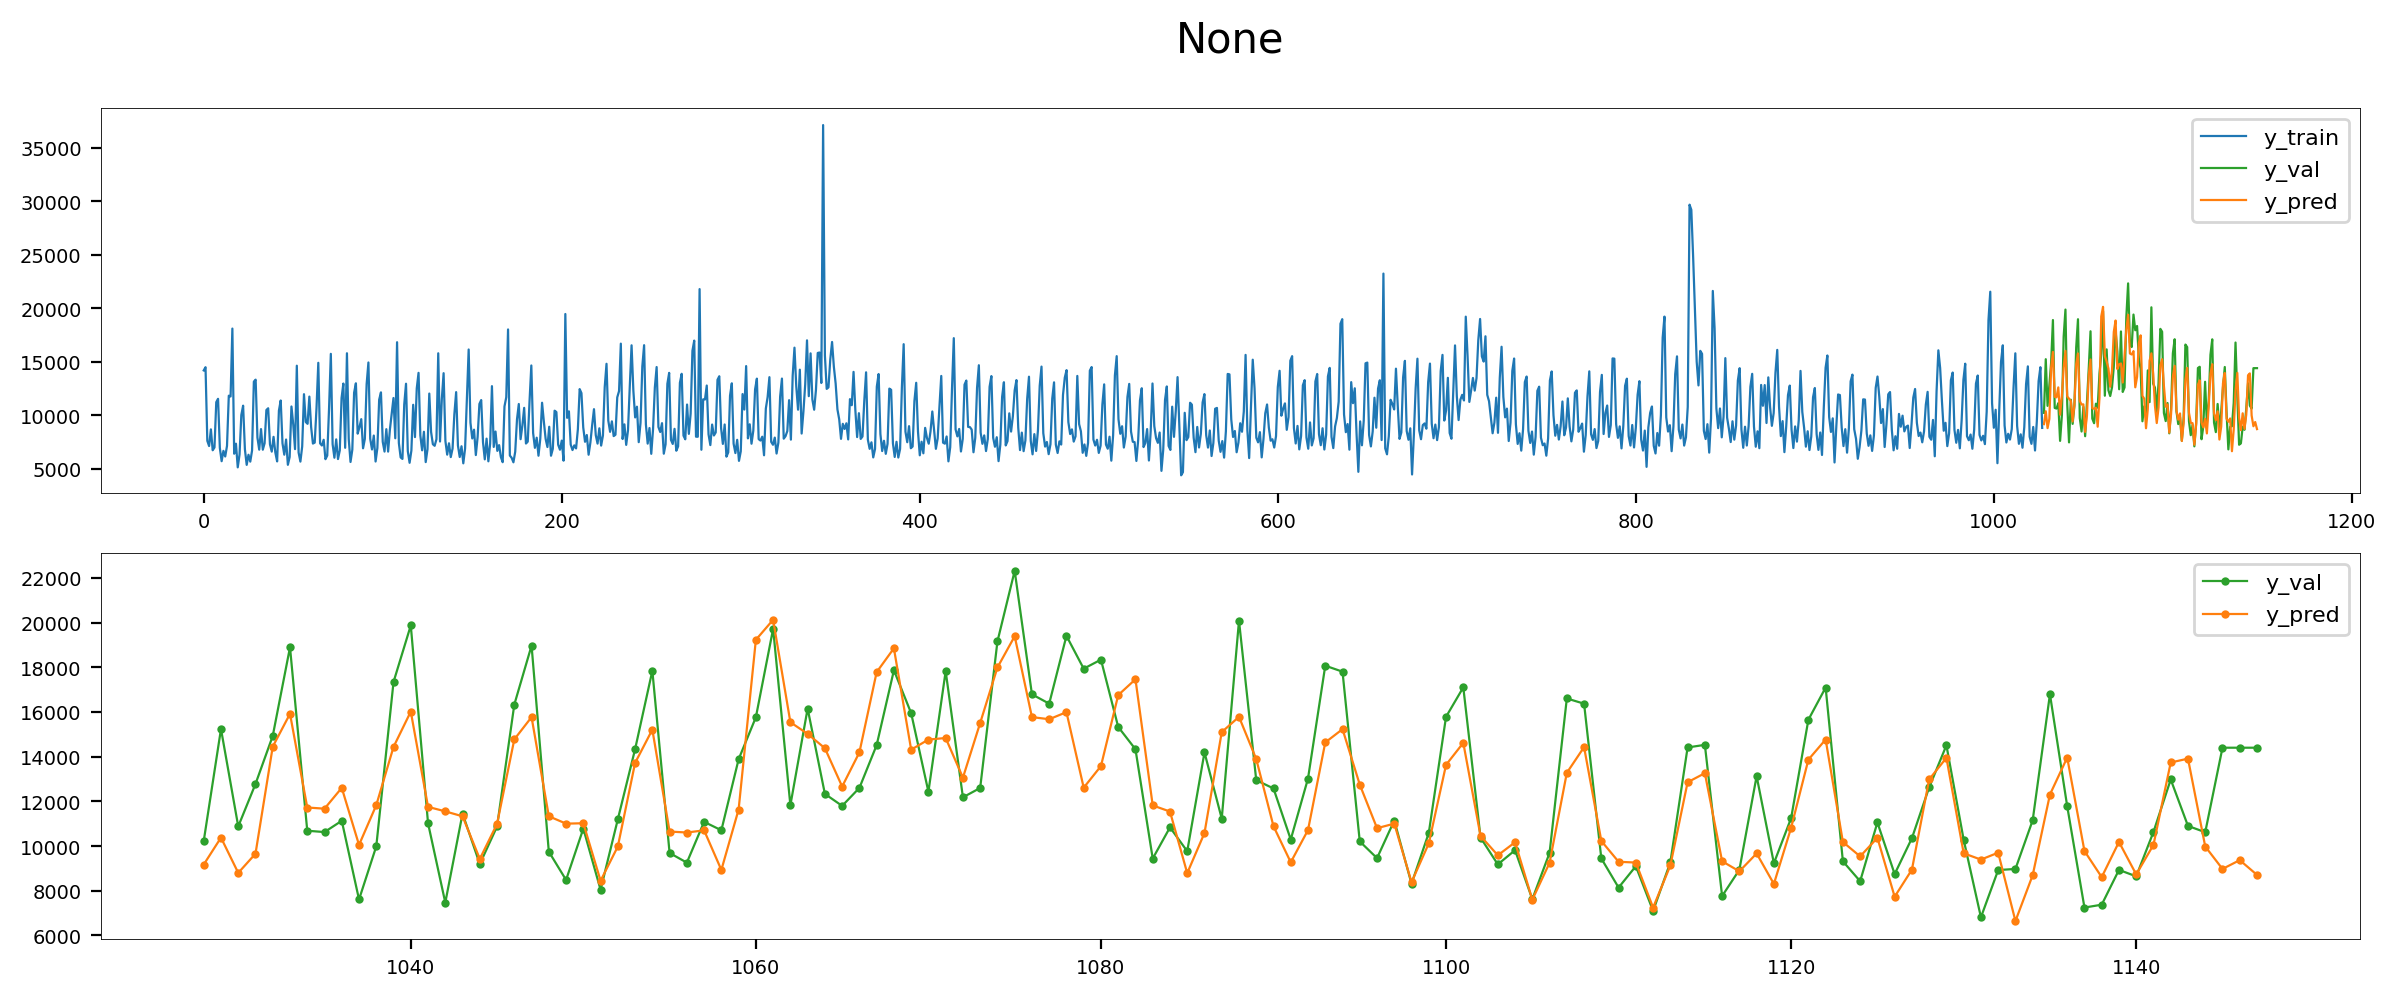

0.6051534927314364
RMSE: 2247.860302179559
MAE: 1785.3735786708194
MAPE: 14.04%
R2-Score: 0.6051534927314364


In [68]:
model12_lin = LinearRegression()
model12_lin.fit(x_train,y_train)
y_pred = model12_lin.predict(x_val)

# 평가
plot_model_result(y_train,y_val,y_pred)
print(model12_lin.score(x_val,y_val))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))


# 6. 3차 모델링: 초기 모델 생성

- Random Forest, LightGBM 알고리즘으로 모델링하고 성능을 기록합니다.
- 하이퍼파라미터 튜닝은 하지 않습니다(모든 파라미터 기본값 사용).
- 우선 Linear Regression 모델보다 성능이 좋은지 비교하는 데 의미를 둡니다.

## (1) Random Forest 모델

### 1) 상품 3 모델링

- 모델 이름은 model03_rdf로 합니다.

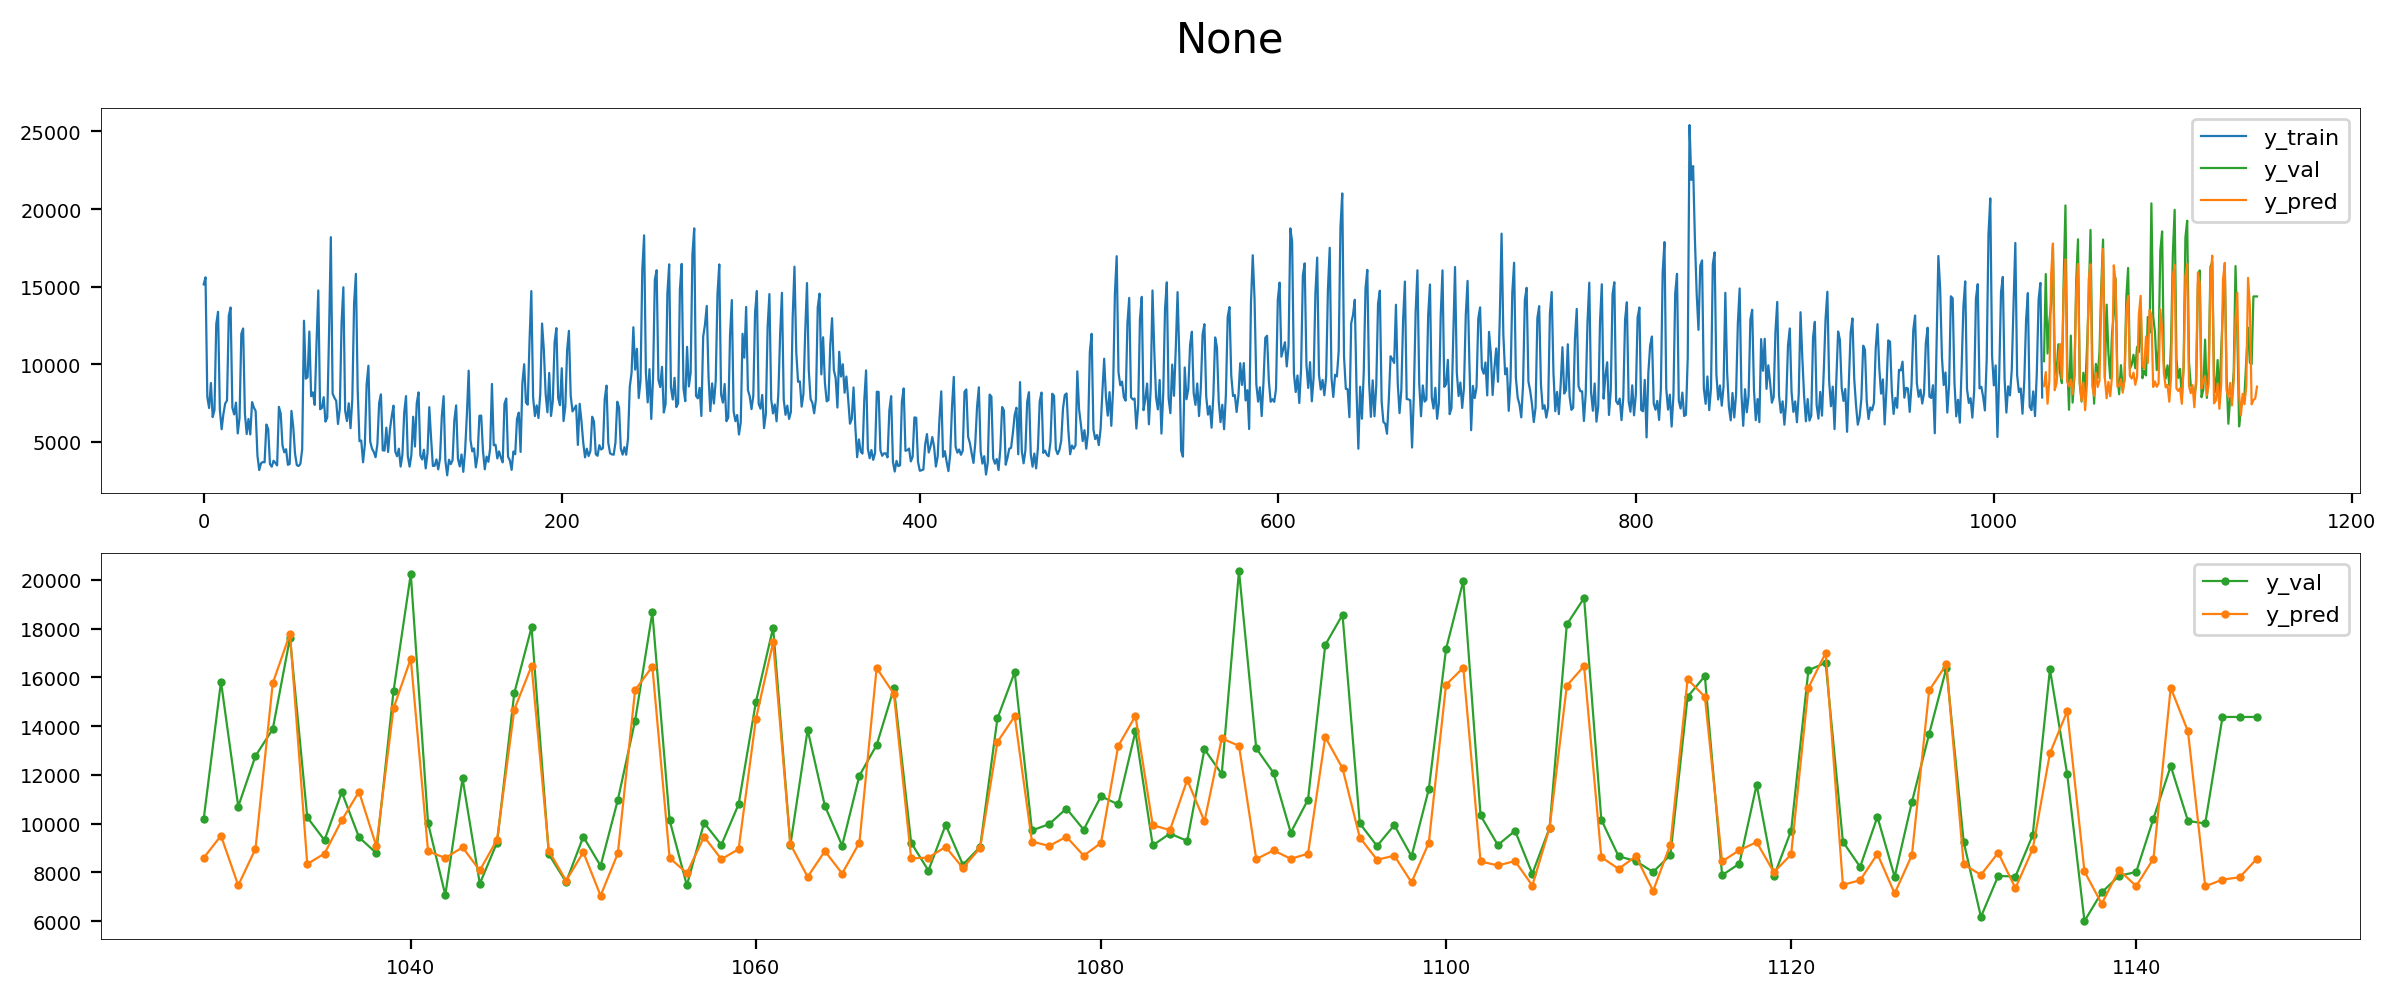

0.5657215655301548
RMSE: 2270.854300114827
MAE: 1652.624166666667
MAPE: 13.71%
R2-Score: 0.5657215655301548


In [72]:
x_train, x_val, y_train, y_val = preproc(data03)
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

model03_rdf = RandomForestRegressor()
model03_rdf.fit(x_train,y_train)
model03_rdf.score(x_val,y_val)
y_pred = model03_rdf.predict(x_val)
# 평가
plot_model_result(y_train,y_val,y_pred)
print(model03_rdf.score(x_val,y_val))

print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))

### 2) 상품 7 모델링

- 모델 이름은 model07_rdf로 합니다.

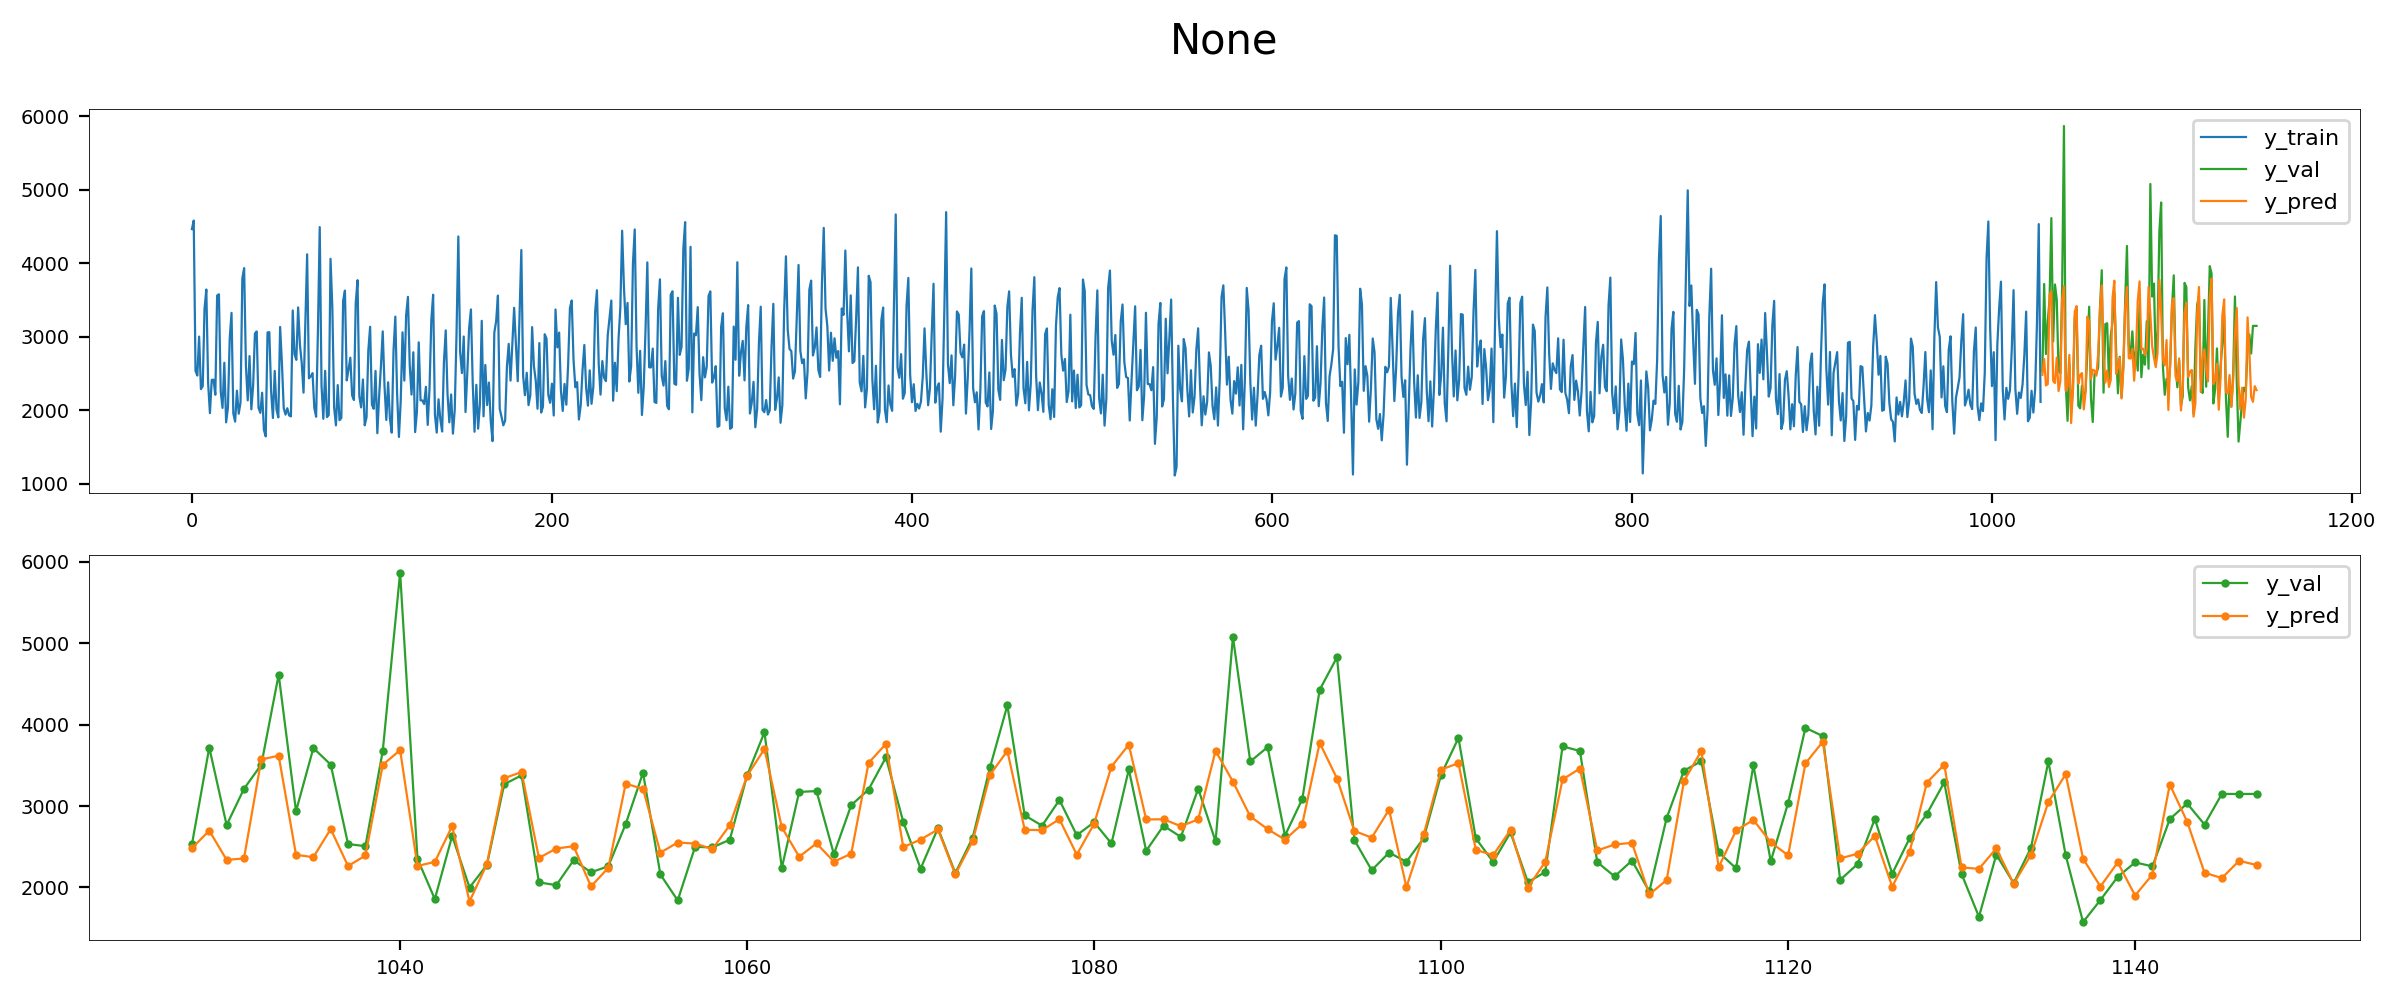

0.4727089083435889
RMSE: 528.7525200412761
MAE: 369.7973333333333
MAPE: 12.54%
R2-Score: 0.4727089083435889


In [74]:
x_train, x_val, y_train, y_val = preproc(data07)
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

model07_rdf = RandomForestRegressor()
model07_rdf.fit(x_train,y_train)
y_pred = model07_rdf.predict(x_val)
# 평가
plot_model_result(y_train,y_val,y_pred)
print(model07_rdf.score(x_val,y_val))

print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))

### 3) 상품 12 모델링

- 모델 이름은 model12_rdf로 합니다.

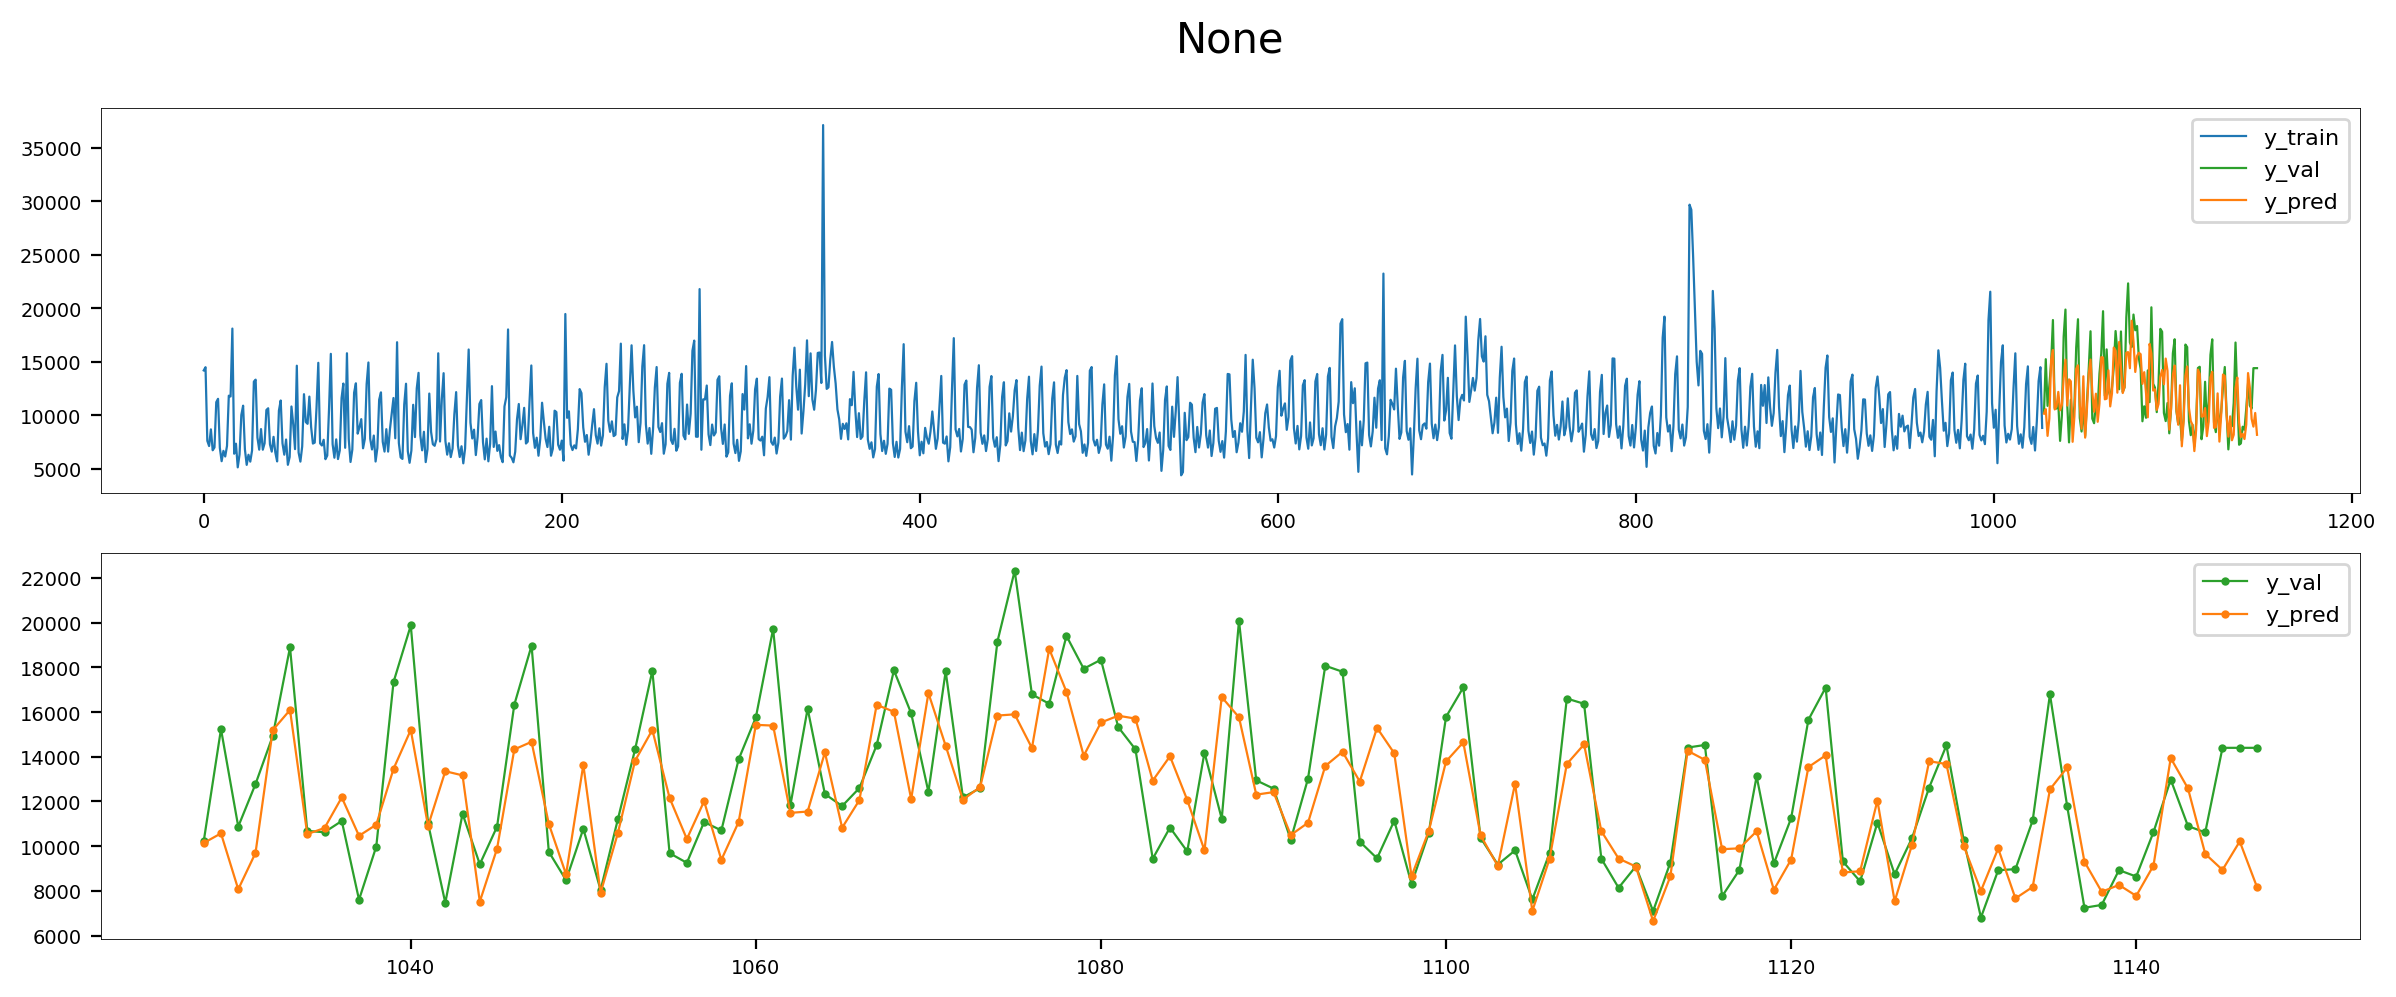

0.4974717376629545
RMSE: 2535.9192073131867
MAE: 1964.52380775
MAPE: 15.38%
R2-Score: 0.4974717376629545


In [76]:
x_train, x_val, y_train, y_val = preproc(data12)

# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

model12_rdf = RandomForestRegressor()
model12_rdf.fit(x_train,y_train)
y_pred = model12_rdf.predict(x_val)
# 평가
plot_model_result(y_train,y_val,y_pred)
print(model12_rdf.score(x_val,y_val))

print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))



## (2) LightGBM 모델

### 1) 상품 3 모델링

- 모델 이름은 model03_lgb로 합니다.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6767
[LightGBM] [Info] Number of data points in the train set: 1028, number of used features: 53
[LightGBM] [Info] Start training from score 8446.116732


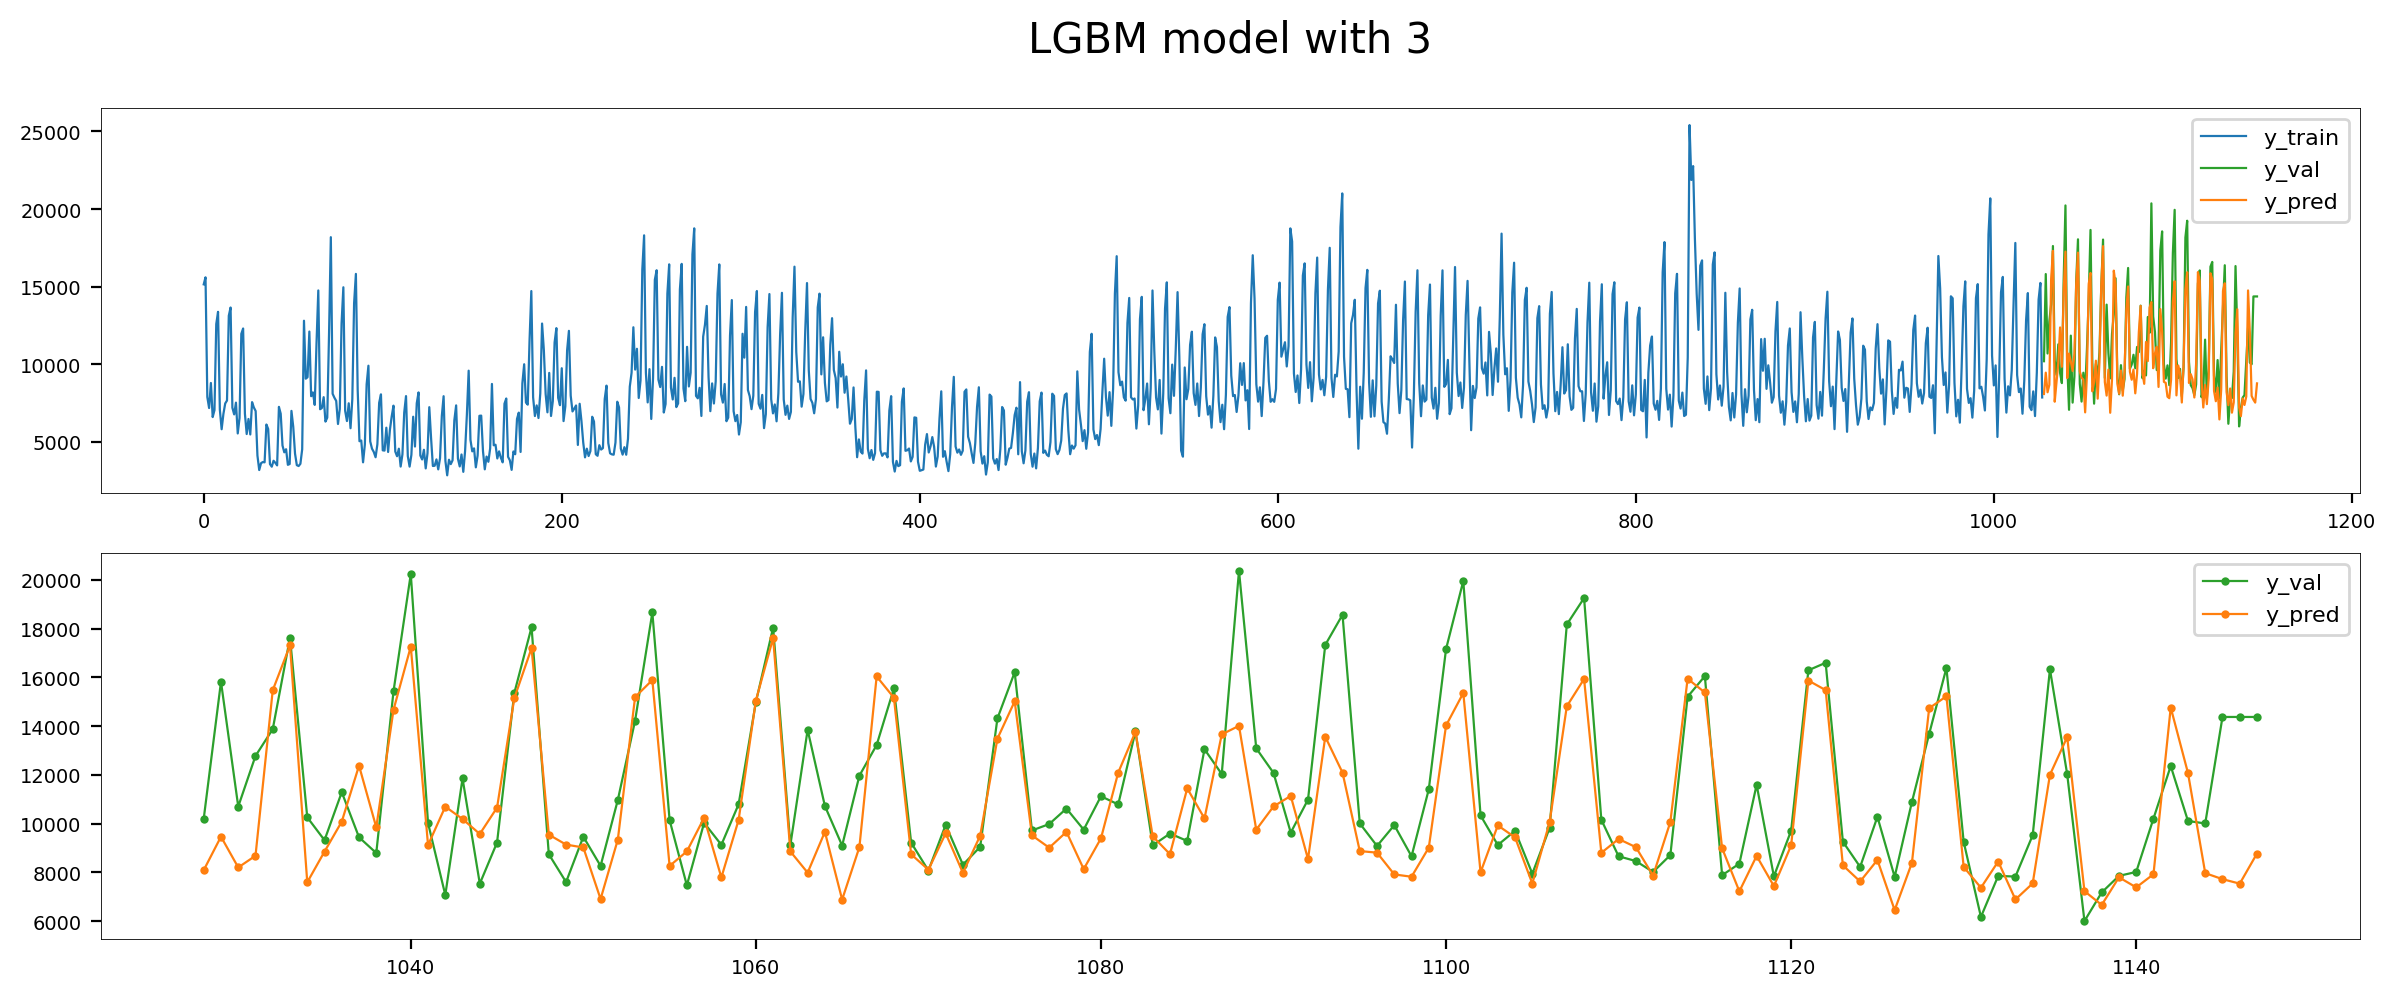

0.5603326549833747
RMSE: 2284.900244186673
MAE: 1698.9362240997102
MAPE: 14.40%
R2-Score: 0.5603326549833747


In [79]:
x_train, x_val, y_train, y_val = preproc(data03)
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

model03_lgb = LGBMRegressor()
model03_lgb.fit(x_train,y_train)
y_pred = model03_lgb.predict(x_val)

# 평가
plot_model_result(y_train,y_val,y_pred , title='LGBM model with 3')
print(model03_lgb.score(x_val,y_val))


print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))

### 2) 상품 7 모델링

- 모델 이름은 model07_lgb로 합니다.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6765
[LightGBM] [Info] Number of data points in the train set: 1028, number of used features: 53
[LightGBM] [Info] Start training from score 2564.388132


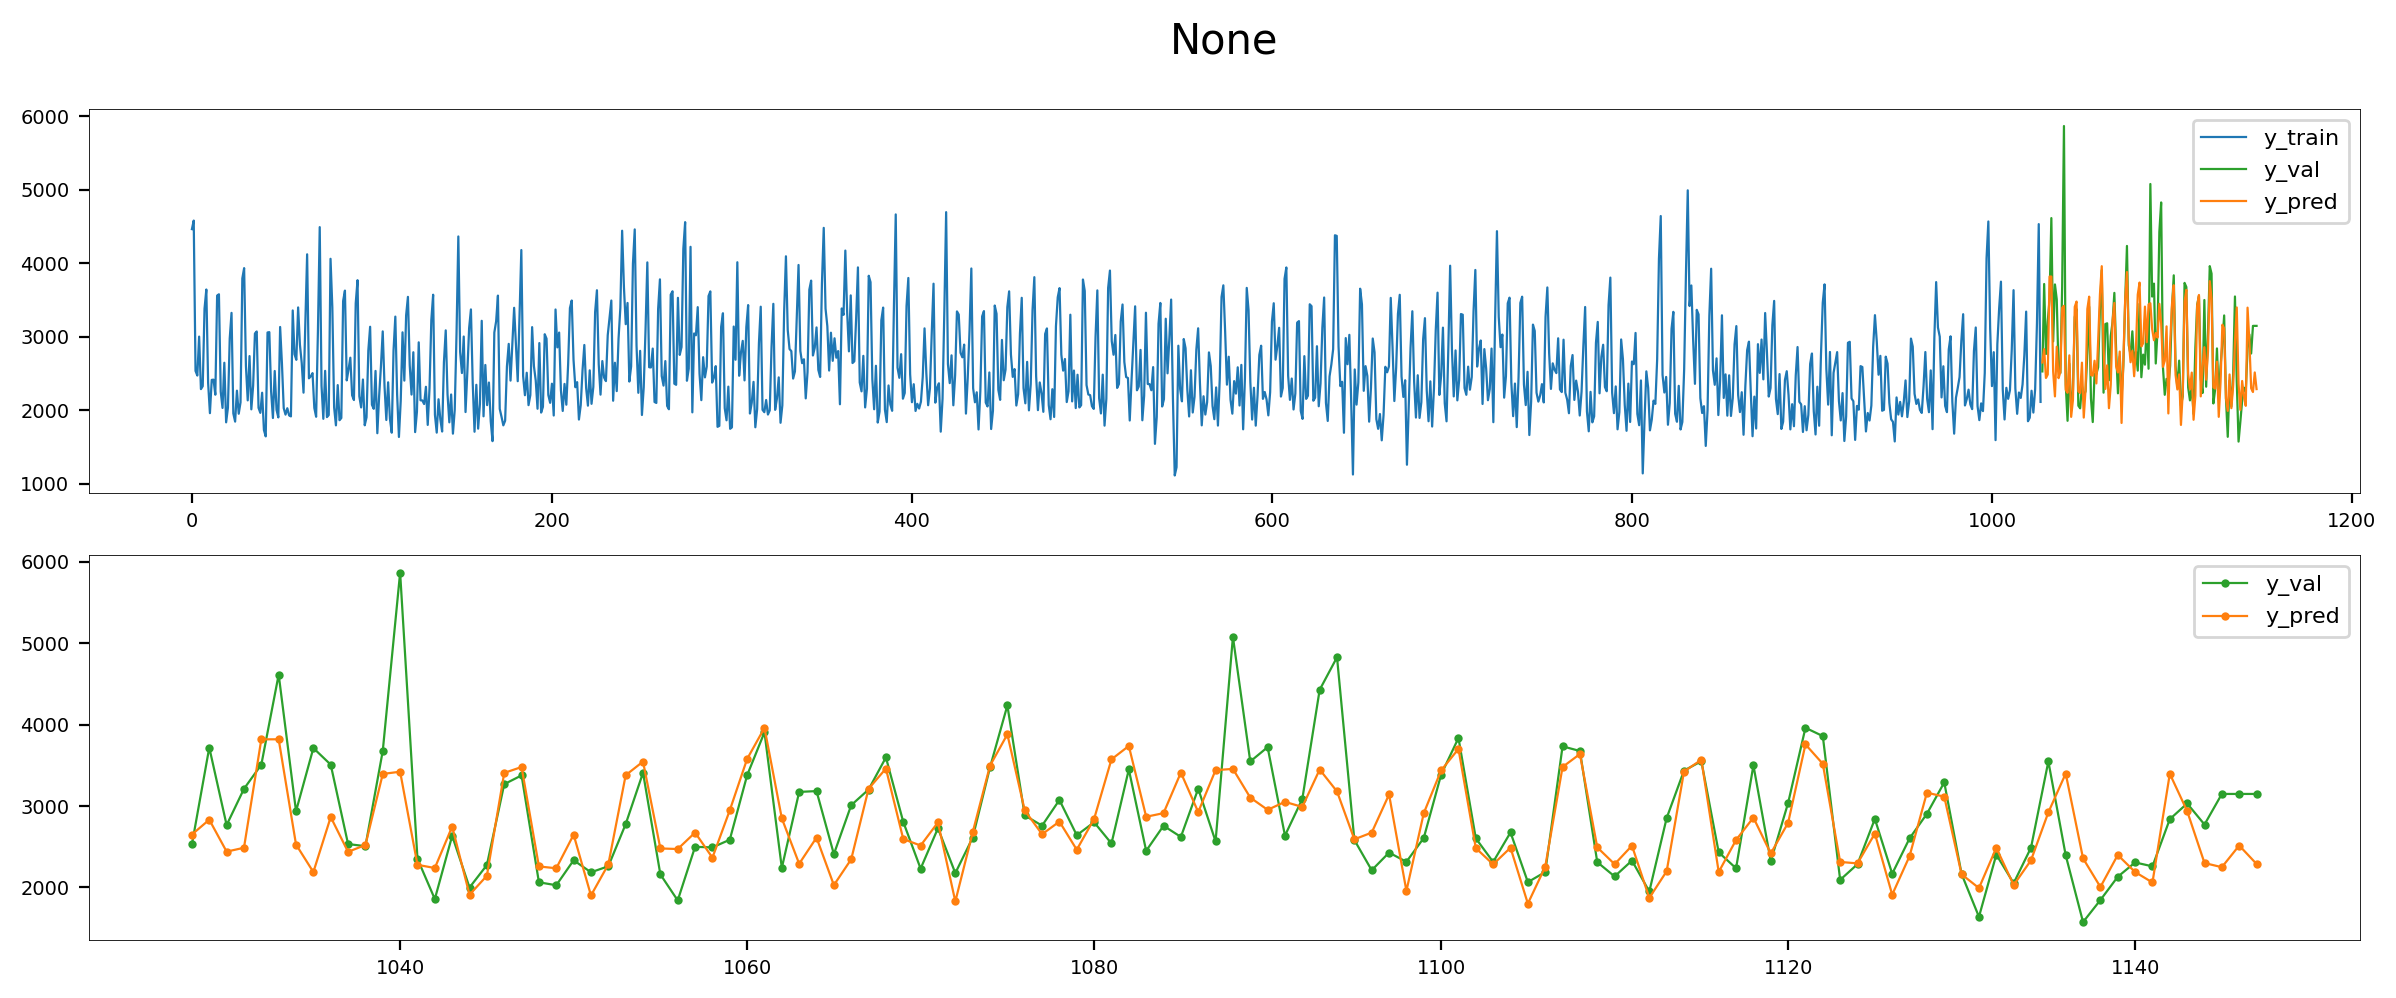

0.48083606727017913
RMSE: 524.6618544427366
MAE: 361.1902308511539
MAPE: 12.29%
R2-Score: 0.48083606727017913


In [81]:
x_train, x_val, y_train, y_val = preproc(data07)
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

model07_lgb = LGBMRegressor()
model07_lgb.fit(x_train,y_train)
y_pred = model07_lgb.predict(x_val)
# 평가
plot_model_result(y_train,y_val,y_pred)
print(model07_lgb.score(x_val,y_val))

print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))

In [138]:
x_train

array([[-0.03403704,  0.08139973,  1.30052777, ..., -0.31163835,
        -0.2489648 , -0.2489648 ],
       [-0.26807408, -0.2856194 ,  1.27080285, ..., -0.31163835,
        -0.2489648 , -0.2489648 ],
       [ 1.34976794,  1.40410788,  1.27080285, ..., -0.31163835,
        -0.2489648 , -0.2489648 ],
       ...,
       [-0.92965536, -1.14631524, -0.50779188, ...,  3.20884766,
        -0.2489648 , -0.2489648 ],
       [-0.10351678, -0.2697872 , -0.51433939, ...,  3.20884766,
        -0.2489648 , -0.2489648 ],
       [ 1.0450322 ,  0.75066991, -0.51433939, ...,  3.20884766,
        -0.2489648 , -0.2489648 ]])

### 3) 상품 12 모델링

- 모델 이름은 model12_lgb로 합니다.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6764
[LightGBM] [Info] Number of data points in the train set: 1028, number of used features: 53
[LightGBM] [Info] Start training from score 9763.344396


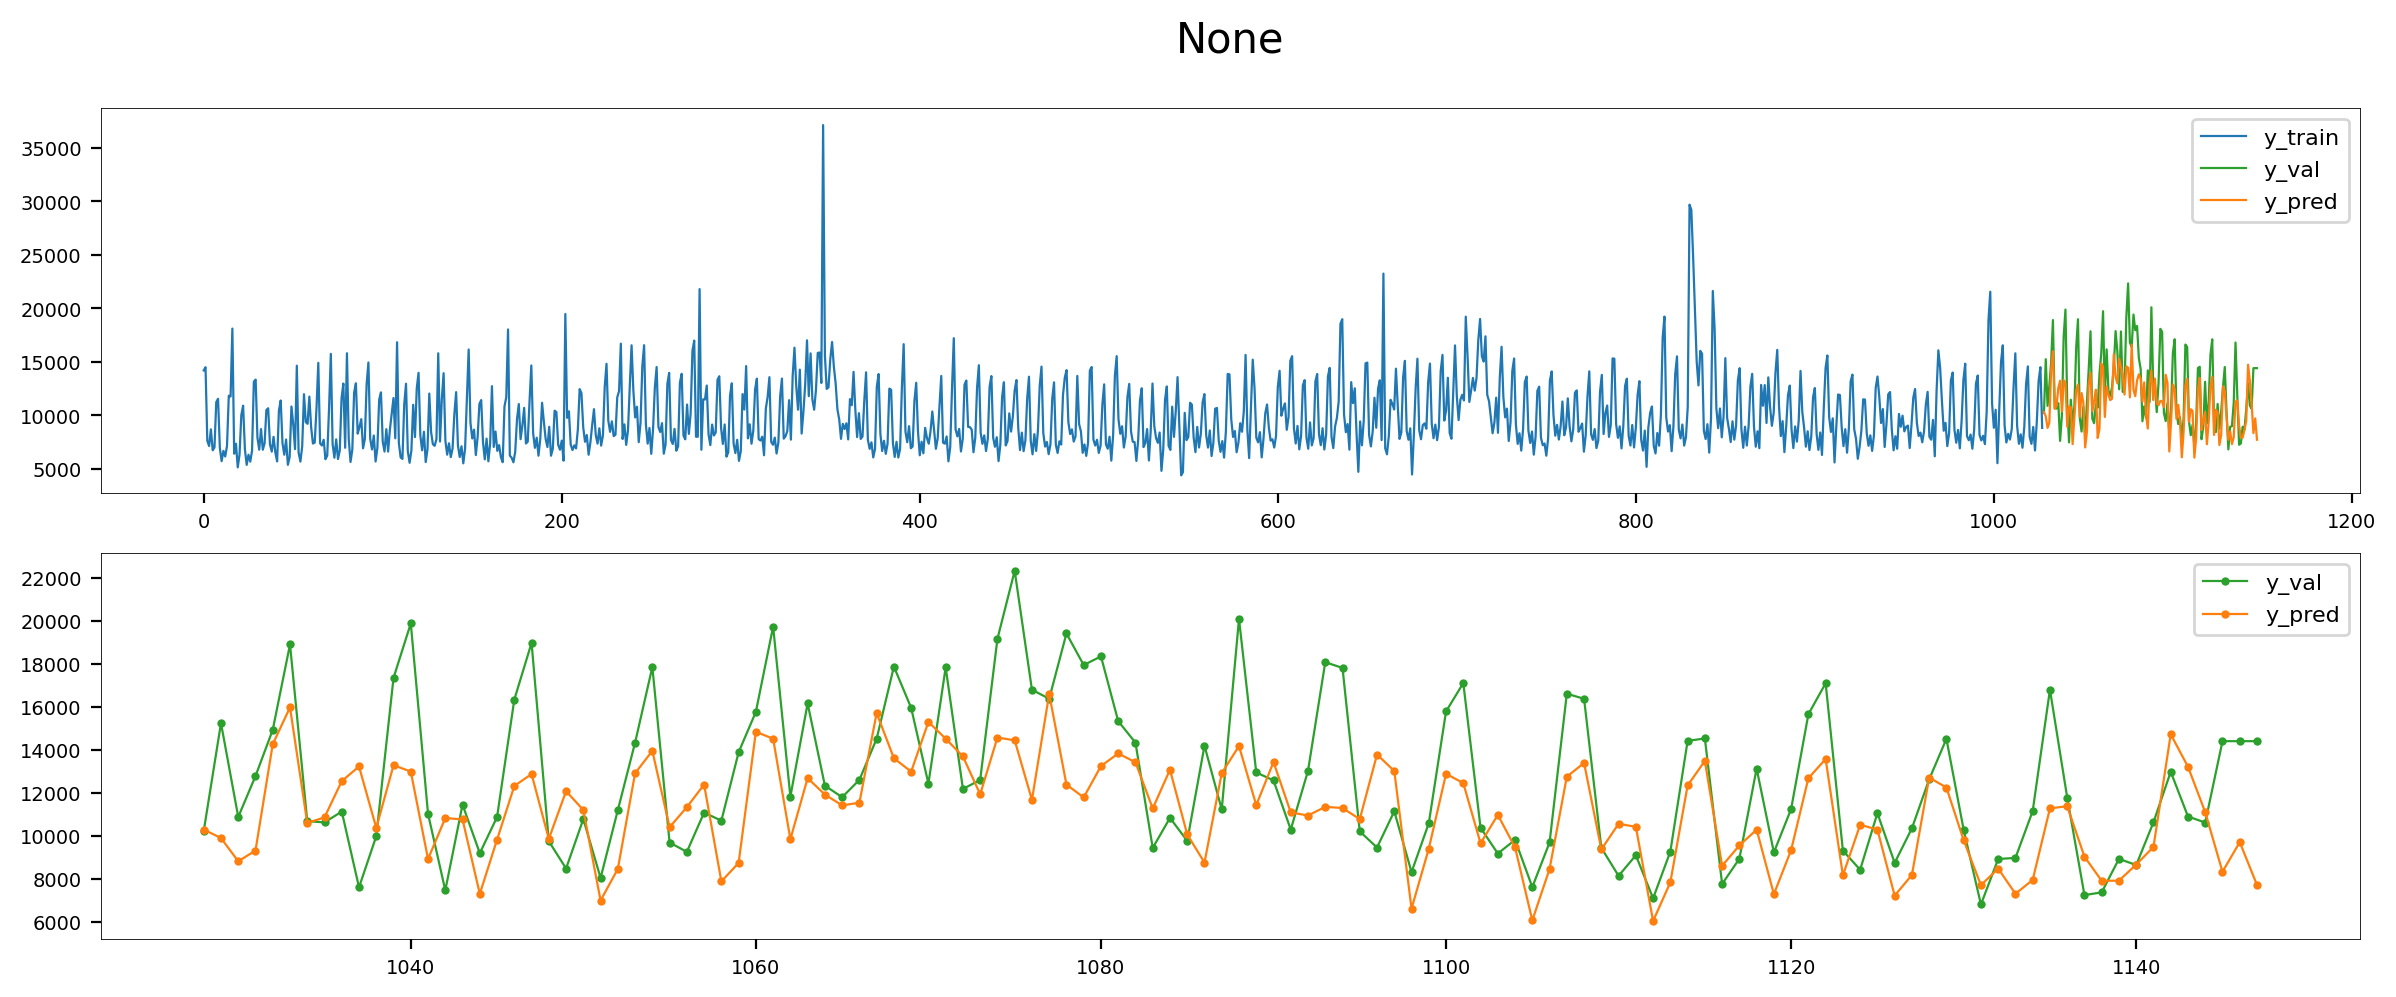

0.2697527968510298
RMSE: 3056.9625506779494
MAE: 2376.2227205927734
MAPE: 17.98%
R2-Score: 0.2697527968510298


In [83]:
x_train, x_val, y_train, y_val = preproc(data12)
# 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

model12_lgb = LGBMRegressor()
model12_lgb.fit(x_train,y_train)
y_pred = model12_lgb.predict(x_val)

# 평가
plot_model_result(y_train,y_val,y_pred)
print(model12_lgb.score(x_val,y_val))

print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MAPE:", f"{mean_absolute_percentage_error(y_val, y_pred) * 100:.2f}%")
print("R2-Score:", r2_score(y_val, y_pred))

# 7. 데이터프레임 저장

- 이후 실습을 위해 최종 구성된 데이터프레임을 파일로 저장합니다.
- joblib룰 사용해 저장할 때는 일반적으로 pkl 확장자를 붙입니다.
- 다음과 같은 형태의 구문으로 저장합니다.
~~~
joblib.dump(mydata, path + 'mydata.pkl')
~~~
- 파일 이름은 다음과 같이 통일합니다.
    - data03.pkl: 3번 상품 데이터 셋
    - data07.pkl: 7번 상품 데이터 셋
    - data12.pkl: 12번 상품 데이터 셋

In [85]:
# 파일 저장
joblib.dump(data03, path + 'data03.pkl')
joblib.dump(data07, path + 'data07.pkl')
joblib.dump(data12, path + 'data12.pkl')

['data12.pkl']

In [86]:
df = joblib.load('data03.pkl')
# 데이터프레임 출력 (옵션)
print(df.head())

        date      qty   count   weekday  month  wti_price  day  is_weekend  \
0 2014-01-02   9853.0  4422.0  Thursday      1  95.140000    2           0   
1 2014-01-03   8647.0  4167.0    Friday      1  94.400000    3           0   
2 2014-01-04  15153.0  5341.0  Saturday      1  94.400000    4           1   
3 2014-01-05  15606.0  5123.0    Sunday      1  94.400000    5           1   
4 2014-01-06   7900.0  3917.0    Monday      1  93.973333    6           0   

   quarter  is_quarter_start  ...  category_min7  weekly_qty_sum  count_city  \
0        1                 0  ...        10142.0          9853.0     45969.0   
1        1                 0  ...         8980.0         18500.0     42386.0   
2        1                 0  ...         8980.0         33653.0     52293.0   
3        1                 0  ...         8980.0         49259.0     49199.0   
4        1                 0  ...         8083.0         57159.0     39105.0   

   city_count_ma7  city_count_std7   FOMC  weekday

In [87]:
df = joblib.load('data07.pkl')
# 데이터프레임 출력 (옵션)
print(df.head())

        date     qty   count   weekday  month  wti_price  day  is_weekend  \
0 2014-01-02  3181.0  4422.0  Thursday      1  95.140000    2           0   
1 2014-01-03  3036.0  4167.0    Friday      1  94.400000    3           0   
2 2014-01-04  4466.0  5341.0  Saturday      1  94.400000    4           1   
3 2014-01-05  4582.0  5123.0    Sunday      1  94.400000    5           1   
4 2014-01-06  2536.0  3917.0    Monday      1  93.973333    6           0   

   quarter  is_quarter_start  ...  category_min7  weekly_qty_sum  count_city  \
0        1                 0  ...         3312.0          3181.0     45969.0   
1        1                 0  ...         3212.0          6217.0     42386.0   
2        1                 0  ...         3212.0         10683.0     52293.0   
3        1                 0  ...         3212.0         15265.0     49199.0   
4        1                 0  ...         2664.0         17801.0     39105.0   

   city_count_ma7  city_count_std7   FOMC  weekday_avg_q

In [88]:
df = joblib.load('data12.pkl')
# 데이터프레임 출력 (옵션)
print(df.head())

        date      qty   count   weekday  month  wti_price  day  is_weekend  \
0 2014-01-02   9647.0  4422.0  Thursday      1  95.140000    2           0   
1 2014-01-03   8879.0  4167.0    Friday      1  94.400000    3           0   
2 2014-01-04  14188.0  5341.0  Saturday      1  94.400000    4           1   
3 2014-01-05  14490.0  5123.0    Sunday      1  94.400000    5           1   
4 2014-01-06   7614.0  3917.0    Monday      1  93.973333    6           0   

   quarter  is_quarter_start  ...  category_min7  weekly_qty_sum  count_city  \
0        1                 0  ...      15195.550          9647.0     45969.0   
1        1                 0  ...      13952.689         18526.0     42386.0   
2        1                 0  ...      13952.689         32714.0     52293.0   
3        1                 0  ...      13952.689         47204.0     49199.0   
4        1                 0  ...      11853.281         54818.0     39105.0   

   city_count_ma7  city_count_std7   FOMC  weekday